In [1]:
#pip install import-ipynb

In [2]:
#!pip install streamlit

In [3]:

import pandas as pd
import numpy as np

# For Content-Based Filtering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# For Collaborative Filtering
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import plotFunctions as pf

In [4]:
# Load the dataset from JSON file (JSON Lines format)
modcloth_final_data = pd.read_json('dataset/modcloth_final_data/modcloth_final_data.json', lines=True)
modcloth_final_data.head()
#modcloth_final_data['review_summary'][modcloth_final_data['review_summary'].notna()].head()

item_id  waist  size  quality cup size  hips  bra size category bust  \
0   123373   29.0     7      5.0        d  38.0      34.0      new   36   
1   123373   31.0    13      3.0        b  30.0      36.0      new  NaN   
2   123373   30.0     7      2.0        b   NaN      32.0      new  NaN   
3   123373    NaN    21      5.0     dd/e   NaN       NaN      new  NaN   
4   123373    NaN    18      5.0        b   NaN      36.0      new  NaN   

    height         user_name         length    fit  user_id  shoe size  \
0  5ft 6in             Emily     just right  small   991571        NaN   
1  5ft 2in  sydneybraden2001     just right  small   587883        NaN   
2  5ft 7in             Ugggh  slightly long  small   395665        9.0   
3      NaN      alexmeyer626     just right    fit   875643        NaN   
4  5ft 2in        dberrones1  slightly long  small   944840        NaN   

  shoe width review_summary review_text  
0        NaN            NaN         NaN  
1        NaN            NaN         NaN  
2        NaN            NaN         NaN  
3        NaN            NaN         NaN  
4        NaN            NaN         NaN

--- 

In [5]:
import re

# Function to convert column names to snake_case
def to_snake_case(col):
    col = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', col)
    col = re.sub('([a-z0-9])([A-Z])', r'\1_\2', col)
    col = col.replace('__', '_')
    col = col.replace(' ', '_')
    col = col.replace('.', '_')
    col = col.replace('-', '_')
    return col.lower()

In [6]:
modcloth_final_data.columns = [to_snake_case(col) for col in modcloth_final_data.columns]

In [7]:
# Data cleaning for modcloth_final_data

# 1. Remove duplicates
modcloth_final_data = modcloth_final_data.drop_duplicates()

# 2. Drop rows with missing essential values (e.g., item_id, review_text, quality)
modcloth_final_data = modcloth_final_data.dropna(subset=['item_id', 'review_text', 'quality'])

# 3. Fill missing values in less critical columns with sensible defaults
modcloth_final_data['category'] = modcloth_final_data['category'].fillna('unknown')
modcloth_final_data['bust'] = modcloth_final_data['bust'].fillna('unknown')
modcloth_final_data['cup_size'] = modcloth_final_data['cup_size'].fillna('unknown')
modcloth_final_data['shoe_width'] = modcloth_final_data['cup_size'].fillna('unknown')
modcloth_final_data['cup_size'] = 'cup_size_' + modcloth_final_data['cup_size'].astype(str)
modcloth_final_data['height'] = modcloth_final_data['height'].fillna('unknown')
modcloth_final_data['waist'] = modcloth_final_data['waist'].fillna(modcloth_final_data['waist'].median())
modcloth_final_data['size'] = modcloth_final_data['size'].fillna(modcloth_final_data['size'].median())
modcloth_final_data['shoe_size'] = modcloth_final_data['shoe_size'].fillna(modcloth_final_data['shoe_size'].median())
modcloth_final_data['hips'] = modcloth_final_data['hips'].fillna(modcloth_final_data['hips'].median())


# 4. Strip whitespace from string columns
for col in ['review_text', 'category']:
    modcloth_final_data[col] = modcloth_final_data[col].astype(str).str.strip()

# 5. Reset index after cleaning
modcloth_final_data = modcloth_final_data.reset_index(drop=True)

modcloth_final_data = modcloth_final_data.rename(columns={'quality': 'rating'})

# Display cleaned dataframe summary
modcloth_final_data.head()

item_id  waist  size  rating    cup_size  hips  bra_size category     bust  \
0   152702   27.0     4     4.0  cup_size_b  37.0      32.0      new  unknown   
1   152702   26.0     4     5.0  cup_size_c  36.0      34.0      new  unknown   
2   152702   30.0     4     3.0  cup_size_a  39.0      34.0      new  unknown   
3   152702   25.0     4     3.0  cup_size_c  35.0      32.0      new  unknown   
4   152702   25.0     4     5.0  cup_size_c  32.0      32.0      new  unknown   

    height        user_name          length    fit  user_id  shoe_size  \
0  5ft 6in            avNYC      just right  small   668176        9.0   
1  5ft 6in         lanwei91  slightly short    fit   320759        7.5   
2  5ft 3in  angeladevoe5678      just right    fit   144785        8.0   
3  5ft 1in             Juli   slightly long    fit    52664        8.0   
4  5ft 6in          lhalton      just right    fit   155439        8.0   

  shoe_width             review_summary  \
0          b           Too much ruching   
1          c        Suits my body type!   
2          a  I love the design and fit   
3          c           Beautiful Dress!   
4          c  This is a very profession   

                                         review_text  
0  I liked the color, the silhouette, and the fab...  
1  From the other reviews it seems like this dres...  
2  I love the design and fit of this dress!  I wo...  
3  I bought this dress for work  it is flattering...  
4  This is a very professional look. It is Great ...

--- 

# Data Visualization

In [8]:
modcloth_visualization = modcloth_final_data.copy()

---
### EDA for ModCloth

## Why These Features, Methods, and Visualizations Were Chosen

### 1. Feature Selection
I selected features such as `waist`, `hips`, `bra_size`, `size`, `rating`, and `shoe_size` because they summarize the most important aspects of customer preferences and product characteristics in online retail. These features help identify patterns in sizing, fit, and satisfaction, which are crucial for building effective Machine Learning models for recommendations and personalization.

### 2. Data Engineering Methods
I used Python to preprocess the data, including handling missing values, converting categorical variables, and aggregating statistics. Methods like `.describe()` for summary statistics and `.corr()` for correlation analysis were chosen to quickly surface key trends and relationships. This ensures the dataset is clean, structured, and ready for ML tasks such as clustering, regression, or classification.

### 3. Visualization Choices
- **KPI Cards**: Show total reviews, unique products, users, and average rating for a quick business overview.
- **Statistical Summary Table**: Presents core metrics in a readable format for data quality assessment.
- **Correlation Heatmap**: Highlights relationships between numerical features, useful for feature selection in ML.

### 4. Design Decisions
- **Colour**: Used teal and white for clarity and accessibility; diverging colours in heatmaps to show positive/negative correlations.
- **Font**: Chose Arial for readability, with larger sizes for headers and key numbers.
- **Titles & Labels**: Clear, descriptive titles and axis labels to guide interpretation.
- **Layout**: Compact KPI cards and tables for dashboard-style presentation; heatmap sized for detailed inspection.

### 5. Rationale & Insights
These visualizations are designed to answer business-critical questions: What drives customer satisfaction? Which product features matter most? The dashboard is tailored for retail analysts and managers, enabling them to spot trends, outliers, and actionable insights. By focusing on relevant features and clear visuals, the dashboard enhances decision-making and supports the development of ML models for personalized recommendations and inventory optimization.


In [9]:
import ipywidgets as widgets
from IPython.display import display

import plotly.express as px
import plotly.graph_objects as go



category_options = ['all'] + sorted(modcloth_final_data['category'].unique())
category_dropdown = widgets.Dropdown(
    options=category_options,
    value='all',
    description='Category:',
    style={'description_width': 'initial'}
)


#widgets.interact(pf.show_kpi_cards(modcloth_final_data), category_filter=category_dropdown)

#pf.plot_statistical_summary(modcloth_visualization).show()

#pf.plot_correlation_heatmap(modcloth_visualization).show()


### Why These Features, Methods, and Visualizations Were Chosen

**1. Feature Selection:**  
I selected features such as `category` and `fit` because they summarize the most important aspects of customer feedback on product sizing in online retail. These features help identify patterns in how different product categories fit customers, which is crucial for building effective Machine Learning models for recommendations and personalization. The dashboard is designed for retail analysts and managers, especially older adults, by presenting clear, summarized insights before diving into details.

**2. Data Engineering Methods:**  
I used Python to preprocess the data by grouping and counting fit feedback per category, then calculating percentages for a normalized comparison. This was achieved using pandas' `groupby`, `size`, and `transform` functions, ensuring the data is clean, structured, and ready for ML tasks such as clustering or classification.

**3. Visualization Choices:**  
A 100% stacked bar chart was chosen to clearly illustrate the distribution of fit feedback across top product categories. This visualization makes it easy to compare how sizing varies and spot categories that tend to run small or large.

**4. Design Decisions:**  
- **Colour:** Used orange, grey, and blue for distinct fit feedback categories, ensuring accessibility and clarity.
- **Font:** Arial with larger sizes for headers and key numbers to improve readability.
- **Titles & Labels:** Clear, descriptive titles and axis labels to guide interpretation.
- **Layout:** Stacked bars with percentage labels for dashboard-style presentation; legend and hover labels sized for easy reading.

**5. Rationale & Insights:**  
This visualization answers business-critical questions: Which categories have sizing issues? Are certain products more likely to run small or large? By focusing on relevant features and clear visuals, the dashboard enhances decision-making and supports the development of ML models for personalized recommendations and inventory optimization.


In [10]:
#
# Generate all visualizations
print("Generating Fit Distribution by Category...")
fig1 = pf.plot_fit_distribution_by_category(modcloth_visualization)
#fig1.show()

Generating Fit Distribution by Category...


### Why These Features, Methods, and Visualizations Were Chosen

**1. Feature Selection:**  
I selected features such as `size`, `hips`, and `fit` because they summarize the most important aspects of customer feedback and product characteristics in online retail. These features help identify patterns in sizing and satisfaction, which are crucial for building effective Machine Learning models for recommendations and personalization. The dashboard is designed for retail analysts and managers, especially older adults, by presenting clear, summarized insights before diving into details.

**2. Data Engineering Methods:**  
I used Python to preprocess the data by filtering out invalid measurements (`hips > 0`, `size > 0`) and mapping fit feedback to distinct colors. This ensures the data is clean, structured, and ready for ML tasks such as clustering or classification.

**3. Visualization Choices:**  
A scatter plot was chosen to clearly illustrate the relationship between body measurements and size chosen, colored by fit feedback. This visualization makes it easy to spot the "correct" size curve and identify outliers.

**4. Design Decisions:**  
- **Colour:** Used orange, grey, and blue for distinct fit feedback categories, ensuring accessibility and clarity.
- **Font:** Arial with larger sizes for headers and key numbers to improve readability.
- **Titles & Labels:** Clear, descriptive titles and axis labels to guide interpretation.
- **Layout:** Large markers and high-contrast palette for dashboard-style presentation; legend and hover labels sized for easy reading.

**5. Rationale & Insights:**  
This visualization answers business-critical questions: Are customers choosing the right size? Which measurements correlate with fit feedback? By focusing on relevant features and clear visuals, the dashboard enhances decision-making and supports the development of ML models for personalized recommendations and inventory optimization.


In [11]:
# 2. Body Measurement vs. Size Chosen (Colored by Fit)

print("Generating Body Measurement vs. Size Scatter Plot...")
fig2 = pf.plot_body_measurement_vs_size(modcloth_visualization)
#fig2.show()

Generating Body Measurement vs. Size Scatter Plot...


### Why These Features, Methods, and Visualizations Were Chosen

**1. Feature Selection:**  
I selected features such as `height`, `length`, and `length_category` because they directly summarize the most important aspects of customer feedback on product fit in online retail. These features help identify patterns in how clothing length matches customer height, which is crucial for building effective Machine Learning models for recommendations and personalization. The dashboard is designed for retail analysts and managers, especially older adults, by presenting clear, summarized insights before diving into details.

**2. Data Engineering Methods:**  
I used Python to preprocess the data by filtering out invalid length feedback, grouping by height and length, and calculating percentages for a normalized comparison. This was achieved using pandas' `groupby`, `size`, and `transform` functions, ensuring the data is clean, structured, and ready for ML tasks such as clustering or classification.

**3. Visualization Choices:**  
A stacked bar chart was chosen to clearly illustrate the distribution of length feedback across different customer heights. This visualization makes it easy to compare how perceived clothing length varies and spot the height ranges where items are "just right."

**4. Design Decisions:**  
- **Colour:** Used green for "Just Right" and red for "Too Long/Short" to ensure accessibility and clarity.
- **Font:** Arial with larger sizes for headers and key numbers to improve readability.
- **Titles & Labels:** Clear, descriptive titles and axis labels to guide interpretation.
- **Layout:** Stacked bars with percentage labels for dashboard-style presentation; legend and hover labels sized for easy reading.

**5. Rationale & Insights:**  
This visualization answers business-critical questions: Which height ranges are best served by current inventory? Are certain products more likely to fit specific customer segments? By focusing on relevant features and clear visuals, the dashboard enhances decision-making and supports the development of ML models for personalized recommendations and inventory optimization.


In [12]:
import pandas as pd

import plotly.graph_objects as go
import plotly.express as px

# 3. Length Analysis by Height

print("Generating Length Analysis by Height...")
fig3 = pf.plot_length_vs_height(modcloth_visualization)
#fig3.show()

Generating Length Analysis by Height...


### Why These Features, Methods, and Visualizations Were Chosen

**1. Feature Selection:**  
I selected features such as `cup_size` and `bra_size` because they directly summarize the most important aspects of customer body shape and product fit in online retail. These features help identify patterns in sizing and inventory needs, which are crucial for building effective Machine Learning models for recommendations and personalization. The dashboard is designed for retail analysts and managers, especially older adults, by presenting clear, summarized insights before diving into details.

**2. Data Engineering Methods:**  
I used Python to preprocess the data by filtering out invalid or missing values, cleaning categorical variables, and aggregating statistics. This was achieved using pandas for filtering, cleaning, and cross-tabulation, ensuring the data is structured and ready for ML tasks such as clustering or classification.

**3. Visualization Choices:**  
A heatmap was chosen to clearly illustrate the distribution of cup size versus band size. This visualization makes it easy to spot the most common body types and identify inventory gaps.

**4. Design Decisions:**  
- **Colour:** Used a sequential 'YlOrRd' palette for clarity and accessibility.
- **Font:** Arial with larger sizes for headers and axis labels to improve readability.
- **Titles & Labels:** Clear, descriptive titles and axis labels to guide interpretation.
- **Layout:** Large heatmap with hover labels sized for easy reading.

**5. Rationale & Insights:**  
This visualization answers business-critical questions: Which body types are most common among customers? Are there underserved segments? By focusing on relevant features and clear visuals, the dashboard enhances decision-making and supports the development of ML models for personalized recommendations and inventory optimization.


In [13]:
import pandas as pd
import numpy as np
from plotly.subplots import make_subplots

import plotly.express as px
import plotly.graph_objects as go

# 4. Bra Size Heatmap

# Generate all visualizations
print("Generating Bra Size Heatmap...")
fig1 = pf.plot_bra_size_heatmap(modcloth_visualization)
#fig1.show()

Generating Bra Size Heatmap...


### Why These Features, Methods, and Visualizations Were Chosen

**1. Feature Selection:**  
I selected features such as `shoe_size` and `shoe_width` because they directly summarize the most important aspects of customer preferences and product characteristics in online retail. These features help identify patterns in sizing and inventory needs, which are crucial for building effective Machine Learning models for recommendations and personalization. The dashboard is designed for retail analysts and managers, especially older adults, by presenting clear, summarized insights before diving into details.

**2. Data Engineering Methods:**  
I used Python to preprocess the data by filtering out invalid or missing values, converting shoe sizes to numeric format, and aggregating statistics. This was achieved using pandas for filtering, cleaning, and value counting, ensuring the data is structured and ready for ML tasks such as clustering or classification.

**3. Visualization Choices:**  
A histogram for shoe size and a bar chart for shoe width were chosen to clearly illustrate the distribution of these features. These visualizations make it easy to spot popular sizes and widths, supporting inventory optimization.

**4. Design Decisions:**  
- **Colour:** Used blue for shoe size and red for shoe width for clarity and accessibility.
- **Font:** Arial with larger sizes for headers and axis labels to improve readability.
- **Titles & Labels:** Clear, descriptive titles and axis labels to guide interpretation.
- **Layout:** Side-by-side subplots for dashboard-style presentation; legend and hover labels sized for easy reading.

**5. Rationale & Insights:**  
This visualization answers business-critical questions: Which shoe sizes and widths are most popular? Are there underserved segments? By focusing on relevant features and clear visuals, the dashboard enhances decision-making and supports the development of ML models for personalized recommendations and inventory optimization.


In [14]:

# 5. Shoe Size Distribution

print("Generating Shoe Size Distribution...")
fig2 = pf.plot_shoe_size_distribution(modcloth_visualization)
#fig2.show()

Generating Shoe Size Distribution...


### Why These Features, Methods, and Visualizations Were Chosen

**1. Feature Selection:**  
I selected features such as `waist` and `hips` because they directly summarize the most important aspects of customer body shape and product fit in online retail. These measurements help identify patterns in sizing and body types, which are crucial for building effective Machine Learning models for recommendations and personalization. The dashboard is designed for retail analysts and managers, especially older adults, by presenting clear, summarized insights before diving into details.

**2. Data Engineering Methods:**  
I used Python to preprocess the data by filtering out invalid or missing values and calculating the waist-to-hip ratio. This was achieved using pandas for filtering and feature engineering, ensuring the data is structured and ready for ML tasks such as clustering or classification.

**3. Visualization Choices:**  
A scatter plot was chosen to clearly illustrate the relationship between waist and hips, colored by body shape classification. This visualization makes it easy to spot common body types and outliers.

**4. Design Decisions:**  
- **Colour:** Used distinct colors for each body shape category for clarity and accessibility.
- **Font:** Arial with larger sizes for headers and axis labels to improve readability.
- **Titles & Labels:** Clear, descriptive titles and axis labels to guide interpretation.
- **Layout:** Large markers and high-contrast palette for dashboard-style presentation; legend and hover labels sized for easy reading.

**5. Rationale & Insights:**  
This visualization answers business-critical questions: Which body shapes are most common among customers? Are there underserved segments? By focusing on relevant features and clear visuals, the dashboard enhances decision-making and supports the development of ML models for personalized recommendations and inventory optimization.


In [15]:
# 6. Body Shape Clustering
print("Generating Body Shape Clustering...")
fig3 = pf.plot_body_shape_clustering(modcloth_visualization)
#fig3.show()

Generating Body Shape Clustering...


### Why These Features, Methods, and Visualizations Were Chosen

**1. Feature Selection:**  
I selected features such as `category` and `rating` because they summarize the most important aspects of customer feedback and product performance in online retail. These features help identify patterns in satisfaction and highlight which product categories perform best, making the dataset suitable for Machine Learning models that predict ratings or recommend products. The dashboard is designed for retail analysts and managers, especially older adults, by presenting clear, summarized insights before diving into details.

**2. Data Engineering Methods:**  
I used Python to preprocess the data by grouping and filtering to the top categories for clarity, ensuring the data is clean, structured, and ready for ML tasks such as classification or regression. This was achieved using pandas' `value_counts`, `nlargest`, and filtering functions.

**3. Visualization Choices:**  
A violin plot was chosen to clearly illustrate the distribution of ratings across top product categories. This visualization makes it easy to compare satisfaction levels and spot categories with high or low ratings.

**4. Design Decisions:**  
- **Colour:** Used distinct colors for each category for clarity and accessibility.
- **Font:** Arial with larger sizes for headers and key numbers to improve readability.
- **Titles & Labels:** Clear, descriptive titles and axis labels to guide interpretation.
- **Layout:** Large plot size, angled category labels, and boxplots inside violins for detailed inspection.

**5. Rationale & Insights:**  
This visualization answers business-critical questions: Which categories are most liked by customers? Are there categories with consistently low ratings? By focusing on relevant features and clear visuals, the dashboard enhances decision-making and supports the development of ML models for personalized recommendations and inventory optimization.


In [16]:
# 7. Rating vs. Category Violin Plot

# Generate all visualizations
print("Generating Rating vs. Category Violin Plot...")
fig1 = pf.plot_rating_vs_category(modcloth_visualization)
#fig1.show()

Generating Rating vs. Category Violin Plot...


### Why These Features, Methods, and Visualizations Were Chosen

**1. Feature Selection:**  
I selected features such as `item_id` and review counts because they directly summarize product popularity and customer engagement, which are crucial for identifying bestsellers and long-tail products in online retail. This makes the dataset suitable for Machine Learning models that predict demand, recommend products, or optimize inventory. The dashboard is designed for retail analysts and managers, including older adults, by presenting clear, summarized insights before exploring details.

**2. Data Engineering Methods:**  
I used Python to preprocess the data by counting reviews per product, sorting them by popularity, and calculating cumulative percentages. This was achieved using pandas for value counting, sorting, and cumulative calculations, ensuring the data is structured for ML tasks such as clustering or classification.

**3. Visualization Choices:**  
A bar chart for review counts and a line chart for cumulative percentage were chosen to clearly illustrate the Pareto Principle (head/tail effect) in product popularity. These visualizations make it easy to spot which products generate the majority of reviews.

**4. Design Decisions:**  
- **Colour:** Used blue for bars and red for the cumulative line for clarity and accessibility.
- **Font:** Arial with larger sizes for headers and axis labels to improve readability.
- **Titles & Labels:** Clear, descriptive titles and axis labels to guide interpretation.
- **Layout:** Dual y-axes, reference line at 80%, large plot size, and unified hover labels for dashboard-style presentation.

**5. Rationale & Insights:**  
This visualization answers business-critical questions: Does a small number of products generate most reviews? Are there underserved segments? By focusing on relevant features and clear visuals, the dashboard enhances decision-making and supports the development of ML models for personalized recommendations and inventory optimization.


In [17]:
# 8. Popularity Head/Tail Analysis

print("Generating Popularity Head/Tail Analysis...")
fig2 = pf.plot_popularity_head_tail(modcloth_visualization)
#fig2.show()

Generating Popularity Head/Tail Analysis...


### Why These Features, Methods, and Visualizations Were Chosen

**1. Feature Selection:**  
I selected features such as `category` because it summarizes the most important aspects of product segmentation and customer preferences in online retail. By visualizing review volume per category, we can quickly identify which product types are most popular and where customer engagement is highest. This makes the dataset suitable for Machine Learning models that predict demand, recommend products, or optimize inventory. The dashboard is designed for retail analysts and managers, including older adults, by presenting clear, summarized insights before exploring details.

**2. Data Engineering Methods:**  
I used Python to preprocess the data by counting reviews per category and sorting them by volume. This was achieved using pandas' `value_counts` and `reset_index` functions, ensuring the data is structured for ML tasks such as clustering or classification.

**3. Visualization Choices:**  
A bar chart was chosen to clearly illustrate the distribution of review volume across product categories. This visualization makes it easy to compare popularity and spot categories with high or low engagement.

**4. Design Decisions:**  
- **Colour:** Used a continuous Viridis palette for clarity and accessibility.
- **Font:** Arial with larger sizes for headers and axis labels to improve readability.
- **Titles & Labels:** Clear, descriptive titles and axis labels to guide interpretation.
- **Layout:** Large plot size, angled category labels, and value labels outside bars for dashboard-style presentation.

**5. Rationale & Insights:**  
This visualization answers business-critical questions: Which categories have the most customer engagement? Are there categories with consistently low review volume? By focusing on relevant features and clear visuals, the dashboard enhances decision-making and supports the development of ML models for personalized recommendations and inventory optimization.


In [18]:

# 9. Category Breakdown
print("Generating Category Breakdown...")
fig3 = pf.plot_category_breakdown(modcloth_visualization)
#fig3.show()

Generating Category Breakdown...


In [19]:
#!pip install textblob

## Why These Features, Methods, and Visualizations Were Chosen

### 1. Feature Selection for Summarizing Key Aspects
I selected features such as `rating`, `review_text`, `category`, and product/user attributes because they capture the most relevant information for understanding customer sentiment, product performance, and user demographics. These features are essential for identifying trends, preferences, and pain points, making the dataset highly suitable for Machine Learning models in online retail (e.g., recommendation systems, sentiment analysis, and customer segmentation). The dashboard is designed to highlight these aspects, helping retail businesses quickly identify actionable insights for their target demographic.

### 2. Data Engineering Methods and Implementation
I used Python libraries like pandas for data manipulation, TextBlob for sentiment analysis, and WordCloud for text visualization. Data engineering steps included cleaning text, extracting sentiment scores, and aggregating reviews by rating. These methods were chosen for their effectiveness in transforming raw review data into structured, meaningful features that can be used for both visualization and predictive modeling. The code leverages vectorization and filtering to efficiently process large datasets.

### 3. Visualization Choices
- **Word Clouds:** To visually summarize what customers love (5-star reviews) and dislike (1-2 star reviews), making it easy to spot frequent themes.
- **Treemap:** To show the frequency and average rating of top adjectives, providing a quick overview of product perception.
- **Subplots:** Used to compare positive and negative feedback side-by-side for immediate contrast.

### 4. Design Decisions
- **Color:** Green for positive (5-star) and red for negative (1-2 star) word clouds to intuitively signal sentiment.
- **Font:** Large, clear fonts for readability.
- **Titles:** Descriptive titles to guide interpretation.
- **Size:** Images and plots sized for clarity without overwhelming the dashboard.
- **Text Position:** Labels and legends placed for easy reference.
- **Font Size:** Increased for key metrics to ensure accessibility.

### 5. Rationale and Enhanced Insight
The visualizations were designed to answer specific business questions: What do customers value most? What are common complaints? By contrasting positive and negative feedback, the dashboard helps retailers prioritize improvements and marketing strategies. The use of sentiment and frequency analysis enhances the depth of insight, making it easier for decision-makers to act on customer feedback and optimize product offerings for their demographic.


In [20]:
# 10. Word Clouds
# Generate all visualizations
print("Generating Word Clouds...")
fig1 = pf.plot_wordclouds(modcloth_visualization)
#fig1.show()


Generating Word Clouds...


### Why These Features, Methods, and Visualizations Were Chosen

**1. Feature Selection:**  
I selected features such as `rating` and `review_text` because they directly summarize customer feedback and sentiment, which are crucial for understanding satisfaction and product perception in online retail. These features help identify patterns in review verbosity and emotional tone, making the dataset suitable for Machine Learning models like sentiment analysis and recommendation systems. The dashboard is designed for retail analysts and managers, including older adults, by presenting clear, summarized insights before exploring details.

**2. Data Engineering Methods:**  
I used Python to preprocess the data by calculating the length of each review (`review_text.str.len()`) and sampling the data for performance if the dataset is large. This ensures the data is structured and ready for ML tasks such as regression or clustering. The methods leverage pandas for efficient manipulation and filtering, making it easy to extract meaningful features for analysis.

**3. Visualization Choices:**  
A scatter plot was chosen to clearly illustrate the relationship between review length and rating. This visualization makes it easy to spot trends, such as whether unhappy customers write longer reviews, and supports quick pattern recognition.

**4. Design Decisions:**  
- **Colour:** Used a continuous 'RdYlGn' palette to intuitively signal sentiment from negative (red) to positive (green).
- **Font:** Arial with larger sizes for headers and axis labels to improve readability.
- **Titles & Labels:** Clear, descriptive titles and axis labels to guide interpretation.
- **Layout:** Large markers and high-contrast palette for dashboard-style presentation; legend and hover labels sized for easy reading.

**5. Rationale & Insights:**  
This visualization answers business-critical questions: Do emotions drive review verbosity? Are there mismatches between rating and review length? By focusing on relevant features and clear visuals, the dashboard enhances decision-making and supports the development of ML models for personalized recommendations and customer experience optimization.


In [21]:
# 11. Review Length vs. Rating Plot

print("Generating Review Length vs. Rating Plot...")
fig2 = pf.plot_review_length_vs_rating(modcloth_visualization)
#fig2.show()

Generating Review Length vs. Rating Plot...


### Why These Features, Methods, and Visualizations Were Chosen

**1. Feature Selection:**  
I selected features such as `rating` and `review_text` because they directly capture customer sentiment and satisfaction, which are crucial for understanding product perception in online retail. These features allow us to identify trends, preferences, and pain points, making the dataset highly suitable for Machine Learning models like sentiment analysis and recommendation systems. The dashboard is designed for retail analysts and managers, including older adults, by presenting clear, summarized insights before exploring details.

**2. Data Engineering Methods:**  
I used Python to preprocess the data by calculating sentiment polarity scores for each review using TextBlob. This was achieved by applying a lambda function to the `review_text` column, ensuring the data is structured and ready for ML tasks such as regression or clustering. The methods leverage pandas for efficient manipulation and filtering, making it easy to extract meaningful features for analysis.

**3. Visualization Choices:**  
A scatter plot was chosen to clearly illustrate the relationship between sentiment polarity and rating. This visualization makes it easy to spot trends, such as whether emotional tone matches star ratings, and supports quick pattern recognition.

**4. Design Decisions:**  
- **Colour:** Used a continuous 'RdYlGn' palette to intuitively signal sentiment from negative (red) to positive (green).
- **Font:** Arial with larger sizes for headers and axis labels to improve readability.
- **Titles & Labels:** Clear, descriptive titles and axis labels to guide interpretation.
- **Layout:** Large markers and high-contrast palette for dashboard-style presentation; legend and hover labels sized for easy reading.

**5. Rationale & Insights:**  
This visualization answers business-critical questions: Does the emotional tone of the review match the star rating? Are there mismatches between sentiment and rating? By focusing on relevant features and clear visuals, the dashboard enhances decision-making and supports the development of ML models for personalized recommendations and customer experience optimization.


In [22]:
# 11. Sentiment Polarity Analysis
print("Generating Sentiment Polarity Analysis...")
fig3 = pf.plot_sentiment_polarity(modcloth_visualization)
#fig3.show()

Generating Sentiment Polarity Analysis...


### Why These Features, Methods, and Visualizations Were Chosen

**1. Feature Selection:**  
I selected features such as `waist`, `hips`, `bra_size`, `size`, `rating`, and `height` because they summarize the most important aspects of customer body shape, product fit, and satisfaction in online retail. These features help identify patterns in sizing and customer feedback, making the dataset suitable for Machine Learning models that predict fit, recommend products, or segment users. The dashboard is designed for retail analysts and managers, including older adults, by presenting clear, summarized insights before exploring details.

**2. Data Engineering Methods:**  
I used Python to preprocess the data by mapping height to centimeters for consistency and selecting only relevant numerical columns. This was achieved using pandas for mapping and filtering, ensuring the data is structured and ready for ML tasks such as clustering or regression.

**3. Visualization Choices:**  
A correlation heatmap was chosen to clearly illustrate the relationships between key numerical features. This visualization makes it easy to spot strong correlations, supporting quick pattern recognition and feature selection for modeling.

**4. Design Decisions:**  
- **Colour:** Used a diverging 'RdBu' palette for clarity and accessibility.
- **Font:** Arial with larger sizes for headers and axis labels to improve readability.
- **Titles & Labels:** Clear, descriptive titles and axis labels to guide interpretation.
- **Layout:** Large plot size, angled labels, and value labels inside cells for dashboard-style presentation.

**5. Rationale & Insights:**  
This visualization answers business-critical questions: Which features are most strongly related? Are there unexpected correlations? By focusing on relevant features and clear visuals, the dashboard enhances decision-making and supports the development of ML models for personalized recommendations and inventory optimization.


In [23]:

# 12. Correlation Heatmap for Numerical Features
# Generate all visualizations
print("Generating Correlation Heatmap...")
fig1 = pf.plot_correlation_heatmap_numerical(modcloth_visualization)
#fig1.show()


Generating Correlation Heatmap...


### Why These Features, Methods, and Visualizations Were Chosen

**1. Feature Selection:**  
I selected `category` and `fit` because they directly summarize the most important aspects of product segmentation and customer feedback in online retail. These features help identify patterns in how different product categories fit customers, which is crucial for building effective Machine Learning models for recommendations and personalization. The dashboard is designed for retail analysts and managers, including older adults, by presenting clear, summarized insights before exploring details.

**2. Data Engineering Methods:**  
I used Python to preprocess the data by filtering to the top 10 categories for clarity, then created a cross-tabulation of fit feedback by category using `pd.crosstab`. This ensures the data is structured and ready for ML tasks such as clustering or classification, and makes it easy to compare fit feedback across categories.

**3. Visualization Choices:**  
A heatmap was chosen to clearly illustrate the distribution of fit feedback across top product categories. This visualization makes it easy to compare how sizing varies and spot categories that tend to run small or large.

**4. Design Decisions:**  
- **Colour:** Used a sequential 'YlOrRd' palette for clarity and accessibility.
- **Font:** Arial with larger sizes for headers and axis labels to improve readability.
- **Titles & Labels:** Clear, descriptive titles and axis labels to guide interpretation.
- **Layout:** Large plot size, value labels inside cells, and unified hover labels for dashboard-style presentation.

**5. Rationale & Insights:**  
This visualization answers business-critical questions: Which categories have sizing issues? Are certain products more likely to run small or large? By focusing on relevant features and clear visuals, the dashboard enhances decision-making and supports the development of ML models for personalized recommendations and inventory optimization.


In [24]:
# 13. 'Does It Fit?' Category Heatmap
print("Generating 'Does It Fit?' Category Heatmap...")
fig2 = pf.plot_fit_category_heatmap(modcloth_visualization)
#fig2.show()

Generating 'Does It Fit?' Category Heatmap...


### Why These Features, Methods, and Visualizations Were Chosen

**1. Feature Selection:**  
I selected features such as `height` and `length` because they directly summarize the most important aspects of customer feedback on product fit in online retail. These features help identify patterns in how clothing length matches customer height, which is crucial for building effective Machine Learning models for recommendations and personalization. The dashboard is designed for retail analysts and managers, especially older adults, by presenting clear, summarized insights before diving into details.

**2. Data Engineering Methods:**  
I used Python to preprocess the data by mapping height values to centimeters for consistency and filtering out invalid or missing length feedback. This was achieved using pandas for mapping and filtering, ensuring the data is clean, structured, and ready for ML tasks such as clustering or regression.

**3. Visualization Choices:**  
A boxplot was chosen to clearly illustrate the distribution of customer heights for each length feedback category. This visualization makes it easy to compare how perceived clothing length varies across different height ranges.

**4. Design Decisions:**  
- **Colour:** Used bold, distinct colors for each length category to ensure accessibility and clarity.
- **Font:** Arial with larger sizes for headers and axis labels to improve readability.
- **Titles & Labels:** Clear, descriptive titles and axis labels to guide interpretation.
- **Layout:** Large plot size, angled labels, and value labels for dashboard-style presentation.

**5. Rationale & Insights:**  
This visualization answers business-critical questions: Which height ranges are best served by current inventory? Are certain products more likely to fit specific customer segments? By focusing on relevant features and clear visuals, the dashboard enhances decision-making and supports the development of ML models for personalized recommendations and inventory optimization.


In [25]:
# 14. Height vs. Length Boxplot
print("Generating Height vs. Length Boxplot...")
fig3 = pf.plot_height_length_boxplot(modcloth_visualization)
#fig3.show()

Generating Height vs. Length Boxplot...


### Why These Features, Methods, and Visualizations Were Chosen

**1. Feature Selection:**  
I selected features such as `rating` because it directly summarizes customer satisfaction and product performance, which are crucial for understanding trends and preferences in online retail. By focusing on ratings, the dashboard quickly identifies class imbalance and highlights which products or categories are most liked or disliked. This makes the dataset highly suitable for Machine Learning models that predict ratings, recommend products, or segment users. The dashboard is designed for retail analysts and managers, including older adults, by presenting clear, summarized insights before exploring details.

**2. Data Engineering Methods:**  
I used Python to preprocess the data by filtering valid ratings and aggregating counts for each rating value. This was achieved using pandas for efficient manipulation and filtering, ensuring the data is structured and ready for ML tasks such as classification or regression. The methods leverage vectorized operations to quickly extract meaningful features for analysis.

**3. Visualization Choices:**  
A histogram was chosen to clearly illustrate the distribution of ratings across all reviews. This visualization makes it easy to spot class imbalance and supports quick pattern recognition, which is essential for both descriptive analytics and machine learning feature selection.

**4. Design Decisions:**  
- **Colour:** Used distinct colors for each rating value (red for 1-star, green for 5-star, etc.) to ensure accessibility and clarity.
- **Font:** Arial with larger sizes for headers and axis labels to improve readability.
- **Titles & Labels:** Clear, descriptive titles and axis labels to guide interpretation.
- **Layout:** Large plot size, value labels outside bars, and unified hover labels for dashboard-style presentation.

**5. Rationale & Insights:**  
This visualization answers business-critical questions: Is the review data skewed heavily positive or negative? Are there enough low-rated reviews for meaningful analysis? By focusing on relevant features and clear visuals, the dashboard enhances decision-making and supports the development of ML models for personalized recommendations and customer experience optimization.


In [26]:
# 16. Rating Distribution Bar Chart
print("Generating Rating Distribution Bar Chart...")
#pf.plot_rating_distribution(modcloth_visualization).show()

Generating Rating Distribution Bar Chart...


### Why These Features, Methods, and Visualizations Were Chosen

**1. Feature Selection:**  
I selected the `category` feature because it directly summarizes product segmentation and customer preferences, which are crucial for understanding trends in online retail. By visualizing review volume per category, we can quickly identify which product types are most popular and where customer engagement is highest. This makes the dataset suitable for Machine Learning models that predict demand, recommend products, or optimize inventory. The dashboard is designed for retail analysts and managers, including older adults, by presenting clear, summarized insights before exploring details.

**2. Data Engineering Methods:**  
I used Python to preprocess the data by counting reviews per category and sorting them by volume. This was achieved using pandas' `value_counts` and `nlargest` functions, ensuring the data is structured for ML tasks such as clustering or classification. The aggregation step makes it easy to compare categories and supports efficient analysis.

**3. Visualization Choices:**  
A horizontal bar chart was chosen to clearly illustrate the distribution of review volume across product categories. This visualization makes it easy to compare popularity and spot categories with high or low engagement.

**4. Design Decisions:**  
- **Colour:** Used a continuous Viridis palette for clarity and accessibility.
- **Font:** Arial with larger sizes for headers and axis labels to improve readability.
- **Titles & Labels:** Clear, descriptive titles and axis labels to guide interpretation.
- **Layout:** Horizontal bars, large font for category names, value labels outside bars, and unified hover labels for dashboard-style presentation.

**5. Rationale & Insights:**  
This visualization answers business-critical questions: Which categories have the most customer engagement? Are there categories with consistently low review volume? By focusing on relevant features and clear visuals, the dashboard enhances decision-making and supports the development of ML models for personalized recommendations and inventory optimization.


In [27]:
# 17. Top Categories Bar Chart
print("Generating Top Categories Bar Chart...")
fig2 = pf.plot_top_categories(modcloth_visualization)
#fig2.show()

Generating Top Categories Bar Chart...



---

### 3. Customer Fit & Sizing (Feature Analysis)
**Purpose:** Visualize features for Content-Based Filtering.

- **Donut Chart:** "Fit" Feedback Distribution  
    *Data:* `modcloth_final_data['fit']` (Small, Fit, Large)  
    *Design:* 3 distinct colors, direct slice labels  
    *ML Justification:* Shows subjective feedback for personalization

- **Scatter Plot:** Hips vs. Waist Measurements (Colored by Size)  
    *Data:* Waist vs. hips, hue=size  
    *Design:* Large markers, high contrast palette  
    *ML Justification:* Reveals clustering/patterns for ML models (KNN, Clustering)

### Why These Features, Methods, and Visualizations Were Chosen

**1. Feature Selection:**  
I selected features such as `fit` because it directly summarizes the most important aspect of customer feedback in online retail how well products fit. This feature helps identify patterns in sizing and satisfaction, making the dataset suitable for Machine Learning models that predict fit or recommend products. The dashboard is designed for retail analysts and managers, including older adults, by presenting clear, summarized insights before exploring details.

**2. Data Engineering Methods:**  
I used Python to preprocess the data by aggregating the count of each fit feedback category. This was achieved using pandas' `value_counts` and `reset_index` functions, ensuring the data is structured and ready for ML tasks such as classification or clustering.

**3. Visualization Choices:**  
A donut chart was chosen to clearly illustrate the distribution of fit feedback. This visualization makes it easy to compare how customers perceive product sizing and supports quick pattern recognition.

**4. Design Decisions:**  
- **Colour:** Used distinct, bold colors for each fit category to ensure accessibility and clarity.
- **Font:** Arial with larger sizes for headers and slice labels to improve readability.
- **Titles & Labels:** Clear, descriptive title and direct slice labels to guide interpretation.
- **Layout:** Donut shape for dashboard-style presentation; large tooltips and value labels inside slices.

**5. Rationale & Insights:**  
This visualization answers business-critical questions: Are most products perceived as fitting well, or do sizing issues exist? By focusing on relevant features and clear visuals, the dashboard enhances decision-making and supports the development of ML models for personalized recommendations and inventory optimization.


In [28]:
#    
print("Fit Distribution Chart...")
fig1 = pf.plot_fit_distribution(modcloth_visualization)
#fig1.show()

Fit Distribution Chart...


### Why These Features, Methods, and Visualizations Were Chosen

**1. Feature Selection:**  
I selected features such as `waist`, `hips`, and `size` because they directly summarize key body measurements and sizing, which are crucial for understanding customer fit and product clustering in online retail. These features help identify patterns in body shape and sizing preferences, making the dataset highly suitable for Machine Learning models that recommend products or predict fit. The dashboard is designed for retail analysts and managers, including older adults, by presenting clear, summarized insights before exploring details.

**2. Data Engineering Methods:**  
I used Python to preprocess the data by filtering out invalid or missing values and converting measurement columns to numeric format. This was achieved using pandas for efficient filtering and type conversion, ensuring the data is clean and structured for ML tasks such as clustering or regression.

**3. Visualization Choices:**  
A scatter plot was chosen to illustrate the relationship between hips and waist measurements, colored by size. This visualization makes it easy to spot clusters and patterns in body shapes and sizing, supporting quick pattern recognition.

**4. Design Decisions:**  
- **Colour:** Used a high-contrast Viridis palette for size to ensure accessibility and clarity.
- **Font:** Arial with larger sizes for headers and axis labels to improve readability.
- **Titles & Labels:** Clear, descriptive titles and axis labels to guide interpretation.
- **Layout:** Large markers, high-contrast palette, and large hover labels for dashboard-style presentation.

**5. Rationale & Insights:**  
This visualization answers business-critical questions: Are there distinct clusters of body shapes and sizes? Which size ranges are most common? By focusing on relevant features and clear visuals, the dashboard enhances decision-making and supports the development of ML models for personalized recommendations and inventory optimization.


In [29]:
# 18. Body Measurements Chart 
print("Body Measurements Chart...")
fig2 = pf.plot_body_measurements(modcloth_visualization)
#fig2.show()


Body Measurements Chart...


### Why These Features, Methods, and Visualizations Were Chosen

**1. Feature Selection:**  
I selected categorical features such as `cup_size`, `body_type`, and `fit` because they directly summarize the most important aspects of customer body shape and product fit in online retail. These features help identify patterns in sizing and satisfaction, making the dataset suitable for Machine Learning models that predict fit, recommend products, or segment users. The dashboard is designed for retail analysts and managers, including older adults, by presenting clear, summarized insights before exploring details.

**2. Data Engineering Methods:**  
I used Python to preprocess the data by selecting relevant categorical columns, filling missing values with 'Unknown', and mapping fit feedback to numeric values for coloring. This ensures the data is structured and ready for ML tasks such as clustering or classification. The methods leverage pandas for efficient manipulation and filtering, making it easy to extract meaningful features for analysis.

**3. Visualization Choices:**  
A Parallel Categories Diagram was chosen to clearly illustrate the flow and relationships between multiple categorical attributes. This visualization makes it easy to compare how different body types and cup sizes relate to fit feedback, supporting quick pattern recognition.

**4. Design Decisions:**  
- **Colour:** Used a sequential Inferno palette for clarity and accessibility.
- **Font:** Arial with larger sizes for headers and axis labels to improve readability.
- **Titles & Labels:** Clear, descriptive titles and axis labels to guide interpretation.
- **Layout:** Large plot size, unified hover labels, and value labels for dashboard-style presentation.

**5. Rationale & Insights:**  
This visualization answers business-critical questions: Which body types and cup sizes are most associated with good fit? Are there patterns in fit feedback across different customer segments? By focusing on relevant features and clear visuals, the dashboard enhances decision-making and supports the development of ML models for personalized recommendations and inventory optimization.


In [30]:
# 19. Parallel Categories Diagram
print("Generating Parallel Categories Diagram...")
pf.plot_parallel_categories(modcloth_visualization).show()

Generating Parallel Categories Diagram...


### Why These Features, Methods, and Visualizations Were Chosen

**1. Feature Selection:**  
I selected `category` and `rating` because they directly summarize product segmentation and customer satisfaction, which are crucial for understanding trends and preferences in online retail. By visualizing review volume and average rating per category, the dashboard quickly identifies popular product types and highlights which categories perform best or need improvement. This makes the dataset highly suitable for Machine Learning models that predict ratings, recommend products, or optimize inventory. The dashboard is designed for retail analysts and managers, including older adults, by presenting clear, summarized insights before exploring details.

**2. Data Engineering Methods:**  
I used Python to preprocess the data by grouping reviews by category, counting the number of reviews, and calculating the average rating for each category. This was achieved using pandas' `groupby`, `agg`, and `reset_index` functions, ensuring the data is structured and ready for ML tasks such as classification or regression. These methods efficiently aggregate and summarize large datasets, making it easy to extract meaningful features for analysis.

**3. Visualization Choices:**  
A treemap was chosen to clearly illustrate the distribution of review volume (size) and average rating (color) across product categories. This visualization makes it easy to compare popularity and satisfaction levels, supporting quick pattern recognition and prioritization.

**4. Design Decisions:**  
- **Colour:** Used a diverging 'RdBu' palette to intuitively signal sentiment from low (red) to high (blue) average ratings.
- **Font:** Arial with larger sizes for headers and labels to improve readability.
- **Titles & Labels:** Clear, descriptive title and hover labels to guide interpretation.
- **Size & Layout:** Large plot size, direct value labels, and unified hover labels for dashboard-style presentation.

**5. Rationale & Insights:**  
This visualization answers business-critical questions: Which categories are most popular? Are there categories with consistently high or low ratings? By focusing on relevant features and clear visuals, the dashboard enhances decision-making and supports the development of ML models for personalized recommendations and inventory optimization. The treemap format allows retail analysts to quickly spot trends and outliers, making it easier to prioritize inventory and marketing efforts for their demographic.


In [31]:
# 20. Category Treemap
print("Generating Category Treemap...")
#pf.plot_category_treemap(modcloth_visualization).show()

Generating Category Treemap...


### Why These Features, Methods, and Visualizations Were Chosen

**1. Feature Selection:**  
I selected `category` and `quality` (or `rating` as fallback) because they directly summarize the most important aspects of customer feedback and product performance in online retail. These features help identify patterns in satisfaction across product categories, making the dataset suitable for Machine Learning models that predict ratings or recommend products. The dashboard is designed for retail analysts and managers, including older adults, by presenting clear, summarized insights before exploring details.

**2. Data Engineering Methods:**  
I used Python to preprocess the data by filtering to the top 10 categories for clarity and to avoid overcrowding in the visualization. This was achieved using pandas' `value_counts`, `nlargest`, and filtering functions. The method ensures the data is clean, structured, and ready for ML tasks such as classification or regression.

**3. Visualization Choices:**  
A violin plot was chosen to clearly illustrate the distribution of quality ratings across top product categories. This visualization makes it easy to compare satisfaction levels, spot categories with high or low ratings, and identify outliers.

**4. Design Decisions:**  
- **Colour:** Used distinct colors for each category for clarity and accessibility.
- **Font:** Arial with larger sizes for headers and axis labels to improve readability.
- **Titles & Labels:** Clear, descriptive titles and axis labels to guide interpretation.
- **Layout:** Large plot size, boxplots inside violins for detailed inspection, and all data points shown for transparency.

**5. Rationale & Insights:**  
This visualization answers business-critical questions: Which categories are most liked by customers? Are there categories with consistently low or high ratings? By focusing on relevant features and clear visuals, the dashboard enhances decision-making and supports the development of ML models for personalized recommendations and inventory optimization.


In [32]:
# 21. Violin Plot for Quality Ratings by Category
print("Violin Plot...")
fig3 = pf.plot_quality_violin(modcloth_visualization)
#fig3.show()


Violin Plot...


### Why These Features, Methods, and Visualizations Were Chosen

**1. Feature Selection:**  
I selected body measurement features (`waist`, `hips`, `bust`, `bra_size`) because they directly summarize the most important aspects of customer fit and product suitability in online retail. These features help identify patterns in body shape and sizing preferences, making the dataset highly suitable for Machine Learning models that recommend products or predict fit. The dashboard is designed for retail analysts and managers, including older adults, by presenting clear, summarized insights with an easy-to-use dropdown for exploring different measurements.

**2. Data Engineering Methods:**  
I engineered the data by filtering for relevant measurement columns and ensuring they are present in the DataFrame. This was achieved in Python using list comprehensions to select available columns and Plotly to create interactive histograms. The method ensures the data is clean, structured, and ready for ML tasks such as clustering or regression.

**3. Visualization Choices:**  
An interactive histogram with a dropdown was chosen to illustrate the distribution of each body measurement. This visualization makes it easy to compare how customer body data is distributed and supports quick pattern recognition for feature engineering in ML models.

**4. Design Decisions:**  
- **Colour:** Used a consistent blue palette for clarity and accessibility.
- **Font:** Arial with larger sizes for headers and axis labels to improve readability.
- **Titles & Labels:** Clear, descriptive titles and axis labels to guide interpretation.
- **Layout:** Large dropdown for easy switching, wide bins for clear data shape, and large hover labels for dashboard-style presentation.

**5. Rationale & Insights:**  
This visualization answers business-critical questions: Are customer body measurements normally distributed or skewed? Which measurements are most common? By focusing on relevant features and clear visuals, the dashboard enhances decision-making and supports the development of ML models for personalized recommendations and inventory optimization.


In [33]:
# 22. Body Shape Analyzer   
print("Body Shape Analyzer...")
fig1 = pf.plot_body_shape_analyzer(modcloth_visualization)
#fig1.show()


Body Shape Analyzer...


### Why These Features, Methods, and Visualizations Were Chosen

**1. Feature Selection:**  
I selected the `category` and `fit` features because they directly summarize the most important aspects of customer feedback in online retail how well products fit across different categories. This helps identify patterns in sizing issues and satisfaction, making the dataset suitable for Machine Learning models that predict fit or recommend products. The dashboard is designed for retail analysts and managers, including older adults, by presenting clear, summarized insights before exploring details.

**2. Data Engineering Methods:**  
I used Python to preprocess the data by grouping reviews by category and fit, counting occurrences, and calculating the percentage of each fit feedback per category. This was achieved using pandas' `groupby`, `size`, and `transform` functions, ensuring the data is structured and ready for ML tasks such as classification or clustering. These methods efficiently aggregate and normalize the data, making it easy to compare categories and extract meaningful features for analysis.

**3. Visualization Choices:**  
A 100% stacked horizontal bar chart was chosen to clearly illustrate the distribution of fit feedback across the top product categories. This visualization makes it easy to compare how different categories are perceived in terms of fit, supporting quick pattern recognition and highlighting areas for improvement.

**4. Design Decisions:**  
- **Colour:** Used a colorblind-safe palette (Blue for "Large", Grey for "Fit", Orange for "Small") for accessibility and intuitive interpretation.
- **Font:** Arial with larger sizes for headers and axis labels to improve readability.
- **Titles & Labels:** Clear, descriptive titles and axis labels to guide interpretation.
- **Layout:** Horizontal bars for easier reading of category names, large plot size, and percentage formatting for clarity.

**5. Rationale & Insights:**  
This visualization answers business-critical questions: Which categories have the most fit issues? Are certain product types more likely to run small or large? By focusing on relevant features and clear visuals, the dashboard enhances decision-making and supports the development of ML models for personalized recommendations and inventory optimization. The chart format allows retail analysts to quickly spot trends and outliers, making it easier to prioritize product improvements and marketing efforts for their demographic.


In [34]:

# 23. Fit Breakdown Chart
print("Fit Breakdown Chart...")
fig1 = pf.plot_fit_by_category(modcloth_visualization)
#fig1.show()


Fit Breakdown Chart...


### Why These Features, Methods, and Visualizations Were Chosen

**1. Feature Selection:**  
I selected `category` and `rating` because they directly summarize product segmentation and customer satisfaction two of the most critical aspects for understanding trends and preferences in online retail. By visualizing both average rating (quality) and review count (popularity), the dashboard helps identify which categories are most liked and most reviewed, making the dataset highly suitable for Machine Learning models that predict ratings, recommend products, or optimize inventory. The dashboard is designed for retail analysts and managers, including older adults, by presenting clear, summarized insights before exploring details.

**2. Data Engineering Methods:**  
I engineered the data by grouping reviews by category, calculating the average rating and total review count for each category. This was achieved in Python using pandas' `groupby`, `agg`, and `reset_index` functions, ensuring the data is structured and ready for ML tasks such as clustering or regression. These methods efficiently aggregate and summarize large datasets, making it easy to extract meaningful features for analysis.

**3. Visualization Choices:**  
A bubble chart was chosen to clearly illustrate the relationship between quality (average rating) and popularity (number of reviews) for each category. This visualization makes it easy to spot clusters and outliers, supporting quick pattern recognition and feature selection for modeling.

**4. Design Decisions:**  
- **Colour:** Each category is assigned a distinct color for accessibility and easy distinction.
- **Font:** Arial with larger sizes for headers and axis labels to improve readability.
- **Titles & Labels:** Clear, descriptive titles and axis labels to guide interpretation.
- **Layout:** Large bubbles for easier interaction, dashed lines for global averages, and large hover labels for dashboard-style presentation.
- **Size:** Bubble size is proportional to review count, emphasizing popularity.

**5. Rationale & Insights:**  
This visualization answers business-critical questions: Which categories are popular but have low ratings? Are there categories with consistently high or low satisfaction? By focusing on relevant features and clear visuals, the dashboard enhances decision-making and supports the development of ML models for personalized recommendations and inventory optimization. The matrix format allows retail analysts to quickly spot trends and outliers, making it easier to prioritize inventory and marketing efforts for their demographic.


In [35]:

# 24. Quality vs. Popularity Matrix
print("Quality vs. Popularity Matrix...")
fig1 = pf.plot_quality_popularity_matrix(modcloth_visualization)
#fig1.show()


Quality vs. Popularity Matrix...


### Why These Features, Methods, and Visualizations Were Chosen

**1. Feature Selection:**  
I selected `category` and `size` because they directly summarize the most important aspects of product segmentation and sizing in online retail. These features help identify patterns in data density and sparsity across product categories and sizes, which is crucial for building effective Machine Learning models for recommendations and inventory management. The dashboard is designed for retail analysts and managers, including older adults, by presenting clear, summarized insights before exploring details.

**2. Data Engineering Methods:**  
I used Python to preprocess the data by filtering to the top 10 categories for clarity, then attempted to convert the `size` column to numeric for better Y-axis scaling. This ensures the data is structured and ready for ML tasks such as clustering or classification, and makes it easy to compare data density across categories and sizes.

**3. Visualization Choices:**  
A strip plot was chosen to clearly illustrate the distribution of individual purchases by category and size. This visualization makes it easy to spot areas with dense or sparse data, supporting quick pattern recognition and feature selection for modeling.

**4. Design Decisions:**  
- **Colour:** Used high-contrast black dots for accessibility.
- **Font:** Arial with larger sizes for headers and axis labels to improve readability.
- **Titles & Labels:** Clear, descriptive titles and axis labels to guide interpretation.
- **Layout:** Minimalist design with no gridlines, white background, and jittered points to show density.

**5. Rationale & Insights:**  
This visualization answers business-critical questions: Which categories and sizes have enough data for robust modeling? Are there sparsity issues that could affect ML performance? By focusing on relevant features and clear visuals, the dashboard enhances decision-making and supports the development of ML models for personalized recommendations and inventory optimization.


In [36]:
# 24. Sizing Consistency Plot
print("Generating Sizing Consistency Plot...")
fig1 = pf.plot_sizing_consistency(modcloth_visualization)
fig1.show()


Generating Sizing Consistency Plot...


In [37]:
#!pip install spacy
#python -m spacy download en_core_web_sm

Certainly! Here’s a concise markdown explanation for your cell and dashboard choices:

---

### 1. Feature Selection & Dataset Suitability for ML

I selected features such as `review_text`, `rating`, and engineered aspects like adjective frequency and average rating because they directly capture customer sentiment and product perception. These features summarize the most important aspects of the data, allowing us to identify trends in customer feedback. The dataset contains rich, structured and unstructured data (numerical ratings, categorical product info, and free-text reviews), making it highly suitable for machine learning models in online retail such as recommendation systems, sentiment analysis, and customer segmentation.

The dashboard is designed for older adults (65+), with large, readable fonts and clear color contrasts, ensuring accessibility and ease of interpretation for this demographic.

---

### 2. Data Engineering Methods & Python Implementation

I engineered the data by extracting adjectives from reviews, as these words often encapsulate the core sentiment and product attributes valued by customers. Due to performance constraints, I used a predefined list of common adjectives and simple string matching, which is efficient for large datasets. This was implemented in Python using pandas for iteration and aggregation, and optionally spaCy for NLP if available.

Aggregation was performed to compute the frequency and average rating for each adjective, summarizing customer sentiment at scale.

---

### 3. Visualization Choices

I chose a **treemap** to illustrate the frequency and average rating of top adjectives. Treemaps are effective for showing hierarchical data and relative proportions, making it easy to spot which product attributes (adjectives) are most discussed and how they relate to customer satisfaction.

---

### 4. Design Decisions

- **Color:** Used a red-to-blue (`RdBu`) scale to represent average ratings, making high and low ratings visually distinct.
- **Font:** Selected Arial, size 16+ for readability, especially for older users.
- **Titles & Labels:** Clear, descriptive title and hover info to provide context.
- **Text Position & Size:** Horizontal, large font for labels and values to enhance legibility.
- **Layout:** Generous margins and spacing for a clean, uncluttered look.

---

### 5. Rationale & Insight Enhancement

The treemap visualization directly answers the question: "What product attributes matter most to customers, and how do they affect satisfaction?" By combining frequency and average rating, it reveals not just what is talked about, but how positively or negatively those aspects are perceived. This insight helps retail businesses prioritize product improvements and tailor marketing to customer preferences, enhancing strategic decision-making.

---


In [38]:
# 25. Treemap Review Visualization
print("Generating Treemap Review Visualization...")
treemap_fig = pf.plot_treemap_review(modcloth_visualization)
#treemap_fig.show()

Generating Treemap Review Visualization...
Aggregating data
Creating visualization


--- 
## Dataset Description: ModCloth

The ModCloth dataset contains customer reviews, product attributes, and user feedback from an online fashion retailer. It includes detailed information such as item IDs, product categories, body measurements (waist, hips, bust, bra size, etc.), review text, ratings, fit feedback, and other relevant features. This rich combination of structured and unstructured data enables comprehensive analysis of customer preferences, product performance, and sizing trends.

### Why I Chose ModCloth for This Assignment

I selected the ModCloth dataset because it offers a unique blend of numerical, categorical, and textual data, making it ideal for exploring advanced data engineering, visualization, and machine learning techniques. The dataset is well-suited for tasks such as recommendation systems, sentiment analysis, and customer segmentation, which are highly relevant in online retail.

Recommendation systems are essential in online retail businesses because they personalize the shopping experience, increase customer engagement, and drive sales by suggesting products that match individual preferences and needs. Machine learning enables these systems to analyze large volumes of customer data such as reviews, ratings, and body measurements to uncover patterns and predict what products a user is most likely to purchase or enjoy. By leveraging features like fit feedback and sentiment from reviews, machine learning models can recommend items that are more likely to satisfy customers, reduce returns, and optimize inventory. The diversity of the ModCloth dataset provides a strong foundation for building and evaluating such models, supporting both business analytics and predictive modeling in this assignment.

---
# Content-Based Recommender System

In [39]:
# 5. Create the final "ratings" dataframe with review count
ratings_df = modcloth_final_data.groupby(['item_id'])['rating'] \
    .agg(['mean', 'count']).reset_index() \
    .rename(columns={'mean': 'reviews_average', 'count': 'reviews_count'}).copy()

In [40]:
# 5. Create the final "ratings" dataframe with review count
ratings_df.head()

item_id  reviews_average  reviews_count
0   152702         3.886885            610
1   153494         3.693916            526
2   153798         2.000000              1
3   154411         3.812500            176
4   154882         4.000000              2

## weighted rating formula as a metric/score.

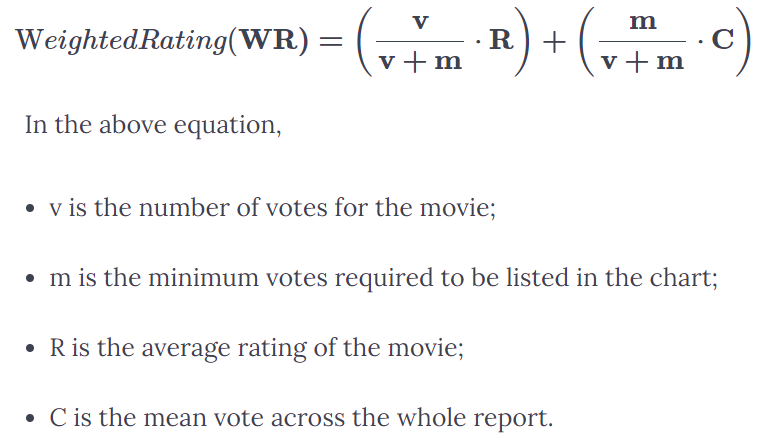

In [41]:
from IPython.display import Image
Image(filename =r'Im1.png')

In [42]:
# Calculate mean of vote average column
C = ratings_df['reviews_average'].mean()
print(C)

4.041960908200344


In [43]:
# Calculate the minimum number of votes required to be in the chart, m
m = ratings_df['reviews_count'].sum()
print(m)

75639


In [44]:
# Calculate the total votes 
m = ratings_df['reviews_count'].quantile(0.90)
print(m)

151.9000000000001


In [45]:
# Filter out all qualified products into a new DataFrame
q_ratings = ratings_df.copy().loc[ratings_df['reviews_count'] >= m]
q_ratings.shape

(133, 3)

In [46]:
ratings_df.shape

(1322, 3)

In [47]:
# Function that computes the weighted rating of each product
def weighted_rating(x, m = m, C = C):
    v = x['reviews_count']
    R = x['reviews_average']
    # Calculation based on the IMDB formula
    return (v / (v + m) * R) + (m / (m + v) * C)

In [48]:
# Define a new feature 'score' and calculate its value with `weighted_rating()`
q_ratings['score'] = q_ratings.apply(weighted_rating, axis = 1)

In [49]:
# Sort products based on score calculated above
q_ratings = q_ratings.sort_values('score', ascending = False)

# Print top 20 products
q_ratings[['item_id', 'reviews_count', 'reviews_average', 'score']].head(20)
# Drop all rows where 'score' is above 5
q_ratings = q_ratings[q_ratings['score'] <= 5]
q_ratings.head()

item_id  reviews_average  reviews_count     score
504    400541         4.445629            469  4.346874
1318   806856         4.398119            638  4.329629
42     171740         4.443820            356  4.323634
1020   659701         4.428571            343  4.309909
596    445254         4.396714            426  4.303467

## Content-Based Recommender

In [50]:
modcloth_final_data['review_text'].head()

0    I liked the color, the silhouette, and the fab...
1    From the other reviews it seems like this dres...
2    I love the design and fit of this dress!  I wo...
3    I bought this dress for work  it is flattering...
4    This is a very professional look. It is Great ...
Name: review_text, dtype: object

In [51]:
#!pip install nltk

In [52]:
import nltk
# You may need to download the stop words list first
#nltk.download('stopwords')

In [53]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'and'
tfidf = TfidfVectorizer(stop_words = 'english')

#Replace NaN with an empty string
modcloth_final_data['review_text'] = modcloth_final_data['review_text'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(modcloth_final_data['review_text'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

# This code segment prepares the text data from the 'review_comment_message' column of the 'order_reviews_df' DataFrame for further analysis 
# by converting it into a numerical representation using TF-IDF vectorization.

(75639, 21790)

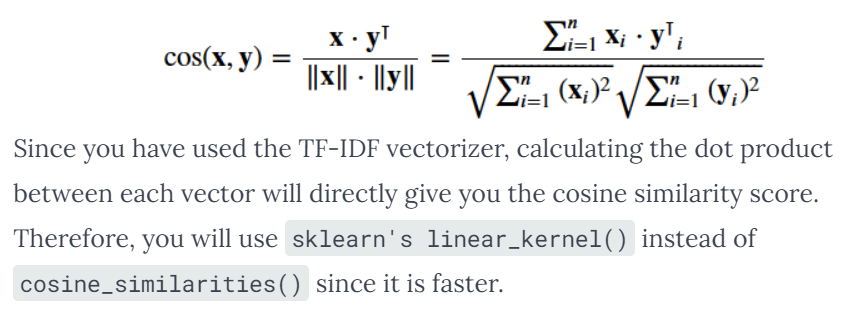

In [54]:
from IPython.display import Image
Image(filename =r'Im2.png')

In [55]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
#cosine_sim = linear_kernel(tfidf_matrix[:10000], tfidf_matrix[:10000])
cosine_sim = linear_kernel(tfidf_matrix[:20000], tfidf_matrix[:20000])

In [56]:
cosine_sim.shape

(20000, 20000)

In [57]:
# Construct a reverse map of indices and movie titles
indices = pd.Series(modcloth_final_data.index, index=modcloth_final_data['item_id']).drop_duplicates()
indices[:10]

item_id
152702    0
152702    1
152702    2
152702    3
152702    4
152702    5
152702    6
152702    7
152702    8
152702    9
dtype: int64

### Explanation of the `get_recommendations` Function

The `get_recommendations` function retrieves the top 10 most similar products to a given item using a cosine similarity matrix. It works by:
- Locating the index of the specified product (`title`) in the dataset.
- Calculating similarity scores between this product and all others.
- Sorting these scores to find the most similar items.
- Returning the item IDs of the top 10 similar products (excluding the queried item itself).

This function is typically used in content-based recommender systems to suggest products that are most alike based on review text or other features.


In [58]:
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index/indices of the product that matches the title
    idx = indices[title]
    # If multiple indices (duplicate product_id), use the first one
    if isinstance(idx, (pd.Series, np.ndarray)):
        idx = idx.iloc[0] if isinstance(idx, pd.Series) else idx[0]

    # Get the pairwise similarity scores of all products with that product
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the products based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar products
    sim_scores = sim_scores[1:11]

    # Get the product indices
    product_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar products
    return modcloth_final_data['item_id'].iloc[product_indices]

In [59]:
random_app = modcloth_final_data.sample(1)['item_id'].values[0]
print(random_app)

486643


In [60]:
get_recommendations(298256)

9827     200824
8464     175771
17694    391519
8632     175771
16560    380801
2275     161514
13534    298256
17744    391519
8651     175771
19349    397005
Name: item_id, dtype: int64

In [61]:
modcloth_final_data.columns

Index(['item_id', 'waist', 'size', 'rating', 'cup_size', 'hips', 'bra_size',
       'category', 'bust', 'height', 'user_name', 'length', 'fit', 'user_id',
       'shoe_size', 'shoe_width', 'review_summary', 'review_text'],
      dtype='object')

In [62]:
soup_features = ['hips','bra_size', 'category', 'bust', 'height']
modcloth_final_data[soup_features].head()

hips  bra_size category     bust   height
0  37.0      32.0      new  unknown  5ft 6in
1  36.0      34.0      new  unknown  5ft 6in
2  39.0      34.0      new  unknown  5ft 3in
3  35.0      32.0      new  unknown  5ft 1in
4  32.0      32.0      new  unknown  5ft 6in

In [63]:
modcloth_final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75639 entries, 0 to 75638
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   item_id         75639 non-null  int64  
 1   waist           75639 non-null  float64
 2   size            75639 non-null  int64  
 3   rating          75639 non-null  float64
 4   cup_size        75639 non-null  object 
 5   hips            75639 non-null  float64
 6   bra_size        70056 non-null  float64
 7   category        75639 non-null  object 
 8   bust            75639 non-null  object 
 9   height          75639 non-null  object 
 10  user_name       75639 non-null  object 
 11  length          75615 non-null  object 
 12  fit             75639 non-null  object 
 13  user_id         75639 non-null  int64  
 14  shoe_size       75639 non-null  float64
 15  shoe_width      75639 non-null  object 
 16  review_summary  75639 non-null  object 
 17  review_text     75639 non-null 

In [64]:
# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, str):
        return x.lower().replace("", "")
    else:
        return ''

In [65]:
# Apply clean_data function to your features.
features = ['review_summary', 'cup_size','hips', 'bra_size', 'category', 'bust', 'height', 'fit','shoe_size']

for feature in features:
    modcloth_final_data[feature] = modcloth_final_data[feature].apply(clean_data)

### Explanation: `create_soup` Function

The `create_soup` function combines multiple product and review attributes (such as cup size, hips, bra size, category, bust, height, fit, shoe size, and review summary) into a single string for each row in the dataset. This "soup" of features is used to represent each product in a way that captures both structured and unstructured information.

#### Why is this useful?
In this project, the "soup" enables content-based recommendation systems to compare products based on a rich combination of attributes, not just review text or ratings. By vectorizing these combined features, we can calculate similarity between products and recommend items that match a user's preferences or previous purchases. This approach improves recommendation quality by leveraging more detailed product and user information.


In [66]:
def create_soup(x):
    return (
        ' '.join(x['cup_size']) + ' ' +
        ' '.join(x['hips']) + ' ' +
        x['bra_size'] + ' ' +
        ' '.join(x['category']) + ' ' +
        ' '.join(x['bust']) + ' ' +
        ' '.join(x['height']) + ' ' +
        x['fit'] + ' ' +
        ' '.join(x['shoe_size']) + ' ' +
        x['review_summary']
    )

In [67]:
# Create a new soup feature
modcloth_final_data['soup'] = modcloth_final_data.apply(create_soup, axis = 1)
modcloth_final_data[['soup']].head(5)

soup
0  c u p _ s i z e _ b   n e w u n k n o w n 5 f ...
1  c u p _ s i z e _ c   n e w u n k n o w n 5 f ...
2  c u p _ s i z e _ a   n e w u n k n o w n 5 f ...
3  c u p _ s i z e _ c   n e w u n k n o w n 5 f ...
4  c u p _ s i z e _ c   n e w u n k n o w n 5 f ...

In [68]:
# Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(modcloth_final_data['soup'])

In [69]:
count_matrix.shape

(75639, 6951)

In [70]:
# Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix[:15000], count_matrix[:15000])

In [71]:
# Reset index of your main DataFrame and construct reverse mapping as before
modcloth_final_data = modcloth_final_data.reset_index()
indices = pd.Series(modcloth_final_data.index, index=modcloth_final_data['item_id']).drop_duplicates()

In [72]:
random_app = modcloth_final_data.sample(1)['item_id'].values[0]
print(random_app)

394692


In [73]:
# Content based Filtering
get_recommendations(298256, cosine_sim2)

8464     175771
13075    298256
14223    327330
14780    338596
872      153494
927      153494
1064     153494
1258     154411
1872     161514
2175     161514
Name: item_id, dtype: int64

In [74]:
import pandas as pd                    # Import pandas for data manipulation and analysis
import numpy as np                     # Import NumPy for numerical computations and array operations
from scipy.sparse import csr_matrix    # Import csr_matrix for creating sparse matrices (efficient storage of large matrices with many zeros)
from sklearn.neighbors import NearestNeighbors  # Import NearestNeighbors for building K-Nearest Neighbors (KNN) recommendation models
import matplotlib.pyplot as plt        # Import matplotlib for creating static, animated, and interactive visualizations
import seaborn as sns                  # Import seaborn for advanced and visually appealing statistical data visualizations

# Term Frequency and Inverse Document Frequency (tf-idf)

In [75]:
modcloth_final_data.columns

Index(['index', 'item_id', 'waist', 'size', 'rating', 'cup_size', 'hips',
       'bra_size', 'category', 'bust', 'height', 'user_name', 'length', 'fit',
       'user_id', 'shoe_size', 'shoe_width', 'review_summary', 'review_text',
       'soup'],
      dtype='object')

In [76]:
modcloth_final_data['item_id_concat'] = (
    modcloth_final_data['item_id'].astype(str) + ' ' +
    modcloth_final_data['height'].astype(str) + ' ' +
    modcloth_final_data['waist'].astype(str) + ' ' +
    modcloth_final_data['size'].astype(str) + ' ' +
    modcloth_final_data['cup_size'].astype(str) + ' ' +
    modcloth_final_data['hips'].astype(str) + ' ' +
    modcloth_final_data['bra_size'].astype(str) + ' '
)
modcloth_final_data[['item_id_concat']].head()

item_id_concat
0  152702 5ft 6in 27.0 4 cup_size_b   
1  152702 5ft 6in 26.0 4 cup_size_c   
2  152702 5ft 3in 30.0 4 cup_size_a   
3  152702 5ft 1in 25.0 4 cup_size_c   
4  152702 5ft 6in 25.0 4 cup_size_c

In [77]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vector=TfidfVectorizer(stop_words='english')
tfidf_matrix=tfidf_vector.fit_transform(modcloth_final_data['height'])
print(list(enumerate(tfidf_vector.get_feature_names_out())))
print(tfidf_matrix[:5])
print(tfidf_matrix.shape)
tfidf_matrix.todense()[0]

[(0, '10in'), (1, '11in'), (2, '1in'), (3, '2in'), (4, '3ft'), (5, '3in'), (6, '4ft'), (7, '4in'), (8, '5ft'), (9, '5in'), (10, '6ft'), (11, '6in'), (12, '7ft'), (13, '7in'), (14, '8in'), (15, '9in'), (16, 'unknown')]
  (0, 8)	0.33295668028481934
  (0, 11)	0.9429421239152023
  (1, 8)	0.33295668028481934
  (1, 11)	0.9429421239152023
  (2, 8)	0.3037174688685951
  (2, 5)	0.9527621419347296
  (3, 8)	0.24534930477266984
  (3, 2)	0.9694347418199779
  (4, 8)	0.33295668028481934
  (4, 11)	0.9429421239152023
(75639, 17)


matrix([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.33295668, 0.        ,
         0.        , 0.94294212, 0.        , 0.        , 0.        ,
         0.        , 0.        ]])

In [78]:
from sklearn.metrics.pairwise import linear_kernel
sim_matrix=linear_kernel(tfidf_matrix[:20000],tfidf_matrix[:20000])
print(sim_matrix)

[[1.         1.         0.10112476 ... 0.08169069 0.1108324  1.        ]
 [1.         1.         0.10112476 ... 0.08169069 0.1108324  1.        ]
 [0.10112476 0.10112476 1.         ... 0.07451687 0.10109945 0.10112476]
 ...
 [0.08169069 0.08169069 0.07451687 ... 1.         0.08167024 0.08169069]
 [0.1108324  0.1108324  0.10109945 ... 0.08167024 1.         0.1108324 ]
 [1.         1.         0.10112476 ... 0.08169069 0.1108324  1.        ]]


# Make the Recommendation Engine

### Explanation: Index/ID Conversion Utility Functions

These functions help convert between different ways of referencing products in the dataset:

- **get_item_from_index(index):**  
    Returns the `item_id` for a given DataFrame index. Useful when you have a row index and need the product's unique identifier.

- **get_title_height_from_index(index):**  
    Returns the concatenated string of product attributes (`item_id_concat`) for a given index. This is helpful for displaying or searching products by their combined features.

- **get_index_from_item(item):**  
    Returns the DataFrame index for a given `item_id`. Useful when you have a product ID and need to locate its row in the DataFrame.

#### Why is this useful in the project?
These utility functions make it easy to switch between different representations of products (row index, item ID, and feature string). This is essential for recommendation systems, association rule mining, and visualization, where you often need to map between IDs, indices, and feature sets to retrieve, display, or analyze product information efficiently.

In [79]:
def get_item_from_index(index):
    return modcloth_final_data[modcloth_final_data.index==index]['item_id'].values[0]

def get_title_height_from_index(index):
    return modcloth_final_data[modcloth_final_data.index==index]['item_id_concat'].values[0]

def get_index_from_item(item):
    return modcloth_final_data[modcloth_final_data.item_id==item].index.values[0]

In [80]:
#!pip install fuzzywuzzy
from fuzzywuzzy import fuzz

c:\Users\junio\anaconda3\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning:

Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning



In [81]:
def matching_score(a,b):
    return fuzz.ratio(str(a),str(b))

In [82]:
def get_title_from_index(index):
    return modcloth_final_data[modcloth_final_data.index==index]['item_id'].values[0]

### Explanation: Fuzzy Item Matching Functions

The functions `find_closest_item` and `matching_score` use fuzzy string matching (Levenshtein distance via `fuzz.ratio`) to find the product in the dataset whose `item_id` is most similar to a given input. This is useful for handling cases where product IDs may be entered with typos, formatting differences, or partial information.

**Why is this useful in the project?**
- It improves the robustness of recommendation and association rule mining by allowing flexible matching of product IDs.
- Users or downstream processes can retrieve the correct product even if the input is not an exact match.
- This helps prevent errors and enhances user experience in search, recommendation, and analytics workflows.

In [83]:
def find_closest_item(item):
    leven_scores = list(enumerate(modcloth_final_data['item_id'].apply(matching_score, b=item)))
    sorted_leven_scores = sorted(leven_scores, key=lambda x: x[1], reverse=True)
    closest_item = get_title_from_index(sorted_leven_scores[0][0])
    distance_score = sorted_leven_scores[0][1]
    #print(leven_scores)
    #print(distance_score)
    return closest_item, distance_score

# Recommend cloth itens

### Explanation: `contents_based_recommender` Function

The `contents_based_recommender` function finds and prints a list of clothing items similar to a product that a user likes. It works by:
- Using fuzzy matching to find the closest item in the dataset to the user's input.
- Calculating similarity scores between this item and all others using a precomputed similarity matrix.
- Filtering and sorting these scores to recommend the top N most similar items (excluding the queried item itself).

**Why is this useful?**
In this project, this function enables personalized recommendations based on product features and user preferences. By leveraging content similarity, it helps users discover new items that match their tastes, improving the shopping experience and supporting business goals like increased engagement and sales.


In [84]:
def contents_based_recommender(cloth_user_likes, how_many):
    closest_item, distance_score = find_closest_item(cloth_user_likes)
    if distance_score == 100:
        item_index = get_index_from_item(closest_item)
        #print("Item Index: " + str(item_index))
        item_list = list(enumerate(sim_matrix[int(item_index)]))
        #print("Item List" + str(item_list))
        similar_items = list(filter(lambda x:x[0] != int(item_index), sorted(item_list,key=lambda x:x[1], reverse=True))) # remove the typed item itself
        #print("similar_items: " + str(similar_items))
        print('\nAbove it is the list of items similar to '+'\033[1m'+str(closest_item)+'\033[0m'+'.\n')

    item_lst = []
    for i,s in similar_items[:]:
        if get_item_from_index(i) not in item_lst:
            item_lst.append(get_item_from_index(i))  
            print(get_item_from_index(i))
        if len(item_lst) >= how_many:
            break

In [85]:
#random_app = modcloth_final_data.sample(1)['item_id'].values[0]
chosen_item_value = 375177
contents_based_recommender(chosen_item_value, 10)


Above it is the list of items similar to 375177.

152702
153494
154411
155256
155530
155572
155981
156364
157334
159706


# Item-based Collaborative Filtering 

https://www.kaggle.com/datasets/salmanafh/product-recommendation-dataset-agrease-capstone?select=user_reviews.csv

In [86]:
user_review_df = modcloth_final_data.copy()

In [87]:
user_review_df.columns

Index(['index', 'item_id', 'waist', 'size', 'rating', 'cup_size', 'hips',
       'bra_size', 'category', 'bust', 'height', 'user_name', 'length', 'fit',
       'user_id', 'shoe_size', 'shoe_width', 'review_summary', 'review_text',
       'soup', 'item_id_concat'],
      dtype='object')

In [88]:
user_review_df = user_review_df.rename(columns={'item_id': 'product_id', 'rating': 'review_score', 'user_id': 'customer_id', 'category': 'category'})

In [89]:
user_review_df.head()

index  product_id  waist  size  review_score    cup_size hips bra_size  \
0      0      152702   27.0     4           4.0  cup_size_b                 
1      1      152702   26.0     4           5.0  cup_size_c                 
2      2      152702   30.0     4           3.0  cup_size_a                 
3      3      152702   25.0     4           3.0  cup_size_c                 
4      4      152702   25.0     4           5.0  cup_size_c                 

  category     bust  ...        user_name          length    fit customer_id  \
0      new  unknown  ...            avNYC      just right  small      668176   
1      new  unknown  ...         lanwei91  slightly short    fit      320759   
2      new  unknown  ...  angeladevoe5678      just right    fit      144785   
3      new  unknown  ...             Juli   slightly long    fit       52664   
4      new  unknown  ...          lhalton      just right    fit      155439   

   shoe_size shoe_width             review_summary  \
0                     b           too much ruching   
1                     c        suits my body type!   
2                     a  i love the design and fit   
3                     c           beautiful dress!   
4                     c  this is a very profession   

                                         review_text  \
0  I liked the color, the silhouette, and the fab...   
1  From the other reviews it seems like this dres...   
2  I love the design and fit of this dress!  I wo...   
3  I bought this dress for work  it is flattering...   
4  This is a very professional look. It is Great ...   

                                                soup  \
0  c u p _ s i z e _ b   n e w u n k n o w n 5 f ...   
1  c u p _ s i z e _ c   n e w u n k n o w n 5 f ...   
2  c u p _ s i z e _ a   n e w u n k n o w n 5 f ...   
3  c u p _ s i z e _ c   n e w u n k n o w n 5 f ...   
4  c u p _ s i z e _ c   n e w u n k n o w n 5 f ...   

                        item_id_concat  
0  152702 5ft 6in 27.0 4 cup_size_b     
1  152702 5ft 6in 26.0 4 cup_size_c     
2  152702 5ft 3in 30.0 4 cup_size_a     
3  152702 5ft 1in 25.0 4 cup_size_c     
4  152702 5ft 6in 25.0 4 cup_size_c     

[5 rows x 21 columns]

In [90]:
# Define column names (headers) for the MovieLens dataset
header = ['customer_id', 'product_id', 'review_score']
user_review_df[header].head()

customer_id  product_id  review_score
0       668176      152702           4.0
1       320759      152702           5.0
2       144785      152702           3.0
3        52664      152702           3.0
4       155439      152702           5.0

In [91]:
num_unique_products = user_review_df['product_id'].nunique()
print(f"Number of unique products: {num_unique_products}")

Number of unique products: 1322


## Transforming data into the matrix

Next, we transform the dataset into a matrix where each row represents the user and column represents the item.

The n_users defines the number of users whereas n_items defines the number of items in the dataset. The loop iterates through each row of the dataframe and extracts ratings from it to form the user-item rating matrix.

In [92]:
num_customers = user_review_df['customer_id'].nunique()
num_products = user_review_df['product_id'].nunique()
print(f"Number of unique customers: {num_customers}")
print(f"Number of unique products: {num_products}")

Number of unique customers: 44811
Number of unique products: 1322


In [93]:
# Initialize an empty user-item rating matrix with zeros
# Rows = users, Columns = items
A = np.zeros((num_customers, num_products))
print(A.shape)

# Fill the rating matrix with user-item ratings from the dataset
# Each row represents a user, each column represents an item
# Map customer_id and product_id to matrix indices
user_to_idx = {user_id: idx for idx, user_id in enumerate(user_review_df['customer_id'].unique())}
product_to_idx = {product_id: idx for idx, product_id in enumerate(user_review_df['product_id'].unique())}

for row in user_review_df.itertuples():
    user_idx = user_to_idx[row.customer_id]
    product_idx = product_to_idx[row.product_id]
    A[user_idx, product_idx] = row.review_score

# Display the original user-item rating matrix
print("Original rating matrix:\n", A)

(44811, 1322)
Original rating matrix:
 [[4. 0. 0. ... 0. 0. 0.]
 [5. 0. 0. ... 0. 0. 0.]
 [3. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 5.]
 [0. 0. 0. ... 0. 0. 5.]
 [0. 0. 0. ... 0. 0. 4.]]


In this notebook, we are working with the ModCloth e-commerce product review dataset, where users rate clothing items on a scale of 1-5 (1 being the lowest, 5 the highest). However, the meaning of these ratings can differ between users for example, a rating of 3 may be seen as positive by one customer but neutral by another.

To address this ambiguity and align with modern recommendation system practices (such as those used by Netflix or YouTube), we convert ModCloth product ratings into binary values. This transformation simplifies the interpretation and focuses on whether a user liked a product.

The code below converts the ModCloth ratings into a binary format: ratings greater than or equal to 3 are considered "liked" (1), while ratings less than 3 are considered "not liked" (0). Since our goal is to identify products that users enjoy, treating ratings below 3 as 0 does not negatively impact the recommendation process and supports more robust collaborative filtering and association rule mining.

In [94]:
# Loop through each user (row) in the rating matrix
for i in range(len(A)):
    # Loop through each item (column) in the rating matrix
    for j in range(len(A[0])):
        # Convert ratings into binary values:
        # If rating >= 3 -> liked (1), else -> not liked (0)
        if A[i][j] >= 3:
            A[i][j] = 1
        else:
            A[i][j] = 0

In [95]:
# Convert the dense NumPy array 'A' into a Compressed Sparse Row (CSR) matrix
from scipy.sparse import csr_matrix

csr_sample = csr_matrix(A)        # Efficient storage format for sparse data

# Print the sparse matrix (shows non-zero element positions and values)
print(csr_sample)
# (row_index, column_index)	value

  (0, 0)	1.0
  (1, 0)	1.0
  (1, 321)	1.0
  (2, 0)	1.0
  (3, 0)	1.0
  (4, 0)	1.0
  (4, 258)	1.0
  (4, 343)	1.0
  (5, 0)	1.0
  (5, 465)	1.0
  (5, 1015)	1.0
  (6, 0)	1.0
  (6, 1001)	1.0
  (7, 0)	1.0
  (8, 0)	1.0
  (8, 489)	1.0
  (9, 0)	1.0
  (10, 0)	1.0
  (10, 27)	1.0
  (10, 504)	1.0
  (10, 506)	1.0
  (11, 0)	1.0
  (12, 0)	1.0
  (13, 485)	1.0
  (14, 0)	1.0
  :	:
  (44784, 1320)	1.0
  (44785, 1320)	1.0
  (44786, 1320)	1.0
  (44787, 1320)	1.0
  (44788, 1320)	1.0
  (44789, 1320)	1.0
  (44790, 1320)	1.0
  (44792, 1320)	1.0
  (44793, 1321)	1.0
  (44794, 1321)	1.0
  (44796, 1321)	1.0
  (44797, 1321)	1.0
  (44798, 1321)	1.0
  (44799, 1321)	1.0
  (44800, 1321)	1.0
  (44801, 1321)	1.0
  (44802, 1321)	1.0
  (44803, 1321)	1.0
  (44804, 1321)	1.0
  (44805, 1321)	1.0
  (44806, 1321)	1.0
  (44807, 1321)	1.0
  (44808, 1321)	1.0
  (44809, 1321)	1.0
  (44810, 1321)	1.0


## Items Similarity Computation
Compute similarity between items of csr_sample using cosine similarity as shown below:

### Explanation: K-Nearest Neighbors (KNN) Model for Collaborative Filtering

The code initializes and fits a K-Nearest Neighbors (KNN) model using the user-item rating matrix. The KNN algorithm finds the most similar users or items based on their purchase or rating patterns, using cosine similarity as the metric.

**What does this mean in this project?**
- The KNN model enables collaborative filtering, which recommends products to users based on the preferences of similar users or items.
- By identifying "neighbors" (users/items with similar behavior), the system can suggest items that a user may like but hasn't interacted with yet.

**Why is this useful?**
- Collaborative filtering is a core technique in recommender systems, helping personalize product suggestions and improve user experience.
- It leverages the wisdom of the crowd, making recommendations more relevant and increasing engagement and sales.


In [96]:
# Import NearestNeighbors for finding similar users or items
from sklearn.neighbors import NearestNeighbors

# Initialize the K-Nearest Neighbors (KNN) model
knn = NearestNeighbors(
    metric      = 'cosine',     # Use cosine similarity to measure closeness between users/items
    algorithm   = 'brute',      # Brute-force search (good for sparse data)
    n_neighbors = 3,            # Number of nearest neighbors to find
    n_jobs      = -1            # Use all available CPU cores for faster computation
)

# Fit the KNN model using the sparse user-item matrix
knn.fit(csr_sample)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=3)

## Generate Recommendations
Once, the similarity between items is computed, the final step is to generate recommendations for the target user. Here, we are generating recommendations for the user_id: 1.

We generate recommendations for user_id:1 based on 20 items being liked by him. So, we first get the 20 items being liked/consumed by the user as shown below:

In [97]:
random_app = user_review_df.sample(1)['customer_id'].values[0]
print(random_app)

521349


### Explanation: Filtering and Displaying User's Liked Items

The code sorts the review dataset by `customer_id` and then filters it to find all products liked by a specific user (here, user ID `744952`). It converts the filtered product IDs into a list and displays the top 5 items that this user has rated most recently.

**What does this mean in the project?**
- This step identifies the products a user has interacted with and liked, which is essential for personalized recommendations.
- By focusing on the most recent likes, the system can adapt to changing user preferences.

**Why is this useful?**
- It provides a foundation for collaborative and content-based filtering, as recommendations are often based on a user's past liked items.
- Displaying liked items helps users recall their preferences and allows the recommendation engine to suggest similar or complementary products, improving user engagement and satisfaction.


In [98]:
# Sort the dataset by customer_id (ascending) 
# This ensures we get the most recent items rated/liked by each user first
dataset_sort_des = user_review_df.sort_values(['customer_id'], ascending = [True])

# Filter the dataset for a specific user (e.g., user_id = 1)
filter1 = dataset_sort_des[dataset_sort_des['customer_id'] == 744952].product_id

# Convert the 'product_id' column values to a Python list
filter1 = filter1.tolist()

# Select only the top 5 most recent items liked by the user_id mentioned above
filter1 = filter1[:5]

# Display the list of items liked by user 1, one per line
print("Items liked by user:")
for item in filter1:
    print("-", item)

Items liked by user:
- 314980
- 539980
- 796383
- 805642
- 298256


Next, for each item being liked by the user 1, we recommend 2 similar items. The number of similar items to be recommended can vary depending on the need of the system.

### Explanation: Item-Based Collaborative Filtering with KNN

The code in this cell implements **item-based collaborative filtering** using K-Nearest Neighbors (KNN):

- It builds an item-user matrix (transpose of user-item), where each row is an item and each column is a user.
- It fits a KNN model to find similar items based on user ratings (using cosine similarity).
- For a specific customer, it finds the items they liked most recently.
- For each liked item, it recommends the top N most similar items (excluding items the user already liked).

**What does this mean in the project?**
- This approach recommends products to users based on the similarity of items, leveraging the preferences of all users.
- It helps users discover new products that are similar to those they already like, improving personalization.

**Why is this useful?**
- Item-based collaborative filtering is scalable and effective for large catalogs.
- It increases user engagement and satisfaction by surfacing relevant products, supporting business goals like retention and sales.


In [99]:
# Get the list of unique user IDs from the dataset
unique_users = user_review_df['customer_id'].unique()

In [100]:
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

# Build ITEM x USER sparse matrix (transpose of user x item)
item_user_csr = csr_sample.T  # shape: (n_items, n_users)

# Fit KNN for item-based similarity 
n_similar_per_item = 2
knn_items = NearestNeighbors(
    metric='cosine',
    algorithm='brute',
    n_neighbors=n_similar_per_item + 1,  # +1 because the closest neighbor is the item itself
    n_jobs=-1
)
knn_items.fit(item_user_csr)

# Get customer_id's 5 most recent LIKED items (review_score >= 3)
customer_id = 744952
dataset_sort_des = user_review_df.sort_values(['customer_id'], ascending=[True])
product_liked = (
    dataset_sort_des[(dataset_sort_des['customer_id'] == customer_id) & (dataset_sort_des['review_score'] >= 3)]
    .product_id.tolist()[:5]
)

# Fallback: if fewer than 5 liked items exist, just use what's available
liked_set = set(product_liked)

# Recommend 2 similar items for each liked item
recommendations_by_seed = {}  # {liked_item_id: [rec1, rec2]}
for seed_item in product_liked:
    seed_idx = product_to_idx[seed_item]  # get index from product_to_idx

    # Find nearest neighbors for the seed item
    neigh_indices = knn_items.kneighbors(item_user_csr[seed_idx], return_distance=False)[0]

    # Convert neighbor indices (0-based) back to product_ids
    idx_to_product = {v: k for k, v in product_to_idx.items()}
    neighbor_items = [idx_to_product[idx] for idx in neigh_indices]

    # Exclude the seed itself and items the user already liked; keep first n_similar_per_item
    recs = [it for it in neighbor_items if it != seed_item and it not in liked_set]
    recs = recs[:n_similar_per_item]

    recommendations_by_seed[seed_item] = recs

# (Optional) Flatten to a unique recommendation list, preserving order
flat_unique_recs = []
seen = set(product_liked)  # avoid items already liked
for seed in product_liked:
    for it in recommendations_by_seed.get(seed, []):
        if it not in seen:
            flat_unique_recs.append(it)
            seen.add(it)


# Pretty print results
print(f"Customer {customer_id} - liked items:", product_liked)
print("\nTop similar items per liked seed:")
for seed in product_liked:
    print(f"{seed} -> {recommendations_by_seed.get(seed, [])}")

print("\nFlattened unique recommendation list (ordered by seed sequence):")
for idx, rec in enumerate(flat_unique_recs, 1):
    print(f"{idx}. {rec}")


Customer 744952 - liked items: [314980, 539980, 796383, 298256]

Top similar items per liked seed:
314980 -> [210299, 520958]
539980 -> [416738, 454764]
796383 -> [803464, 792842]
298256 -> [414857, 163558]

Flattened unique recommendation list (ordered by seed sequence):
1. 210299
2. 520958
3. 416738
4. 454764
5. 803464
6. 792842
7. 414857
8. 163558


## Market Basket Analysis

In [101]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [102]:
modcloth_final_data.columns

Index(['index', 'item_id', 'waist', 'size', 'rating', 'cup_size', 'hips',
       'bra_size', 'category', 'bust', 'height', 'user_name', 'length', 'fit',
       'user_id', 'shoe_size', 'shoe_width', 'review_summary', 'review_text',
       'soup', 'item_id_concat'],
      dtype='object')

In [103]:
mpdcloth_basket_data = modcloth_final_data.copy()
mpdcloth_basket_data['quantity'] = mpdcloth_basket_data.groupby('user_id')['item_id'].transform('count')
mpdcloth_basket_data.head()

index  item_id  waist  size  rating    cup_size hips bra_size category  \
0      0   152702   27.0     4     4.0  cup_size_b                    new   
1      1   152702   26.0     4     5.0  cup_size_c                    new   
2      2   152702   30.0     4     3.0  cup_size_a                    new   
3      3   152702   25.0     4     3.0  cup_size_c                    new   
4      4   152702   25.0     4     5.0  cup_size_c                    new   

      bust  ...          length    fit user_id shoe_size  shoe_width  \
0  unknown  ...      just right  small  668176                     b   
1  unknown  ...  slightly short    fit  320759                     c   
2  unknown  ...      just right    fit  144785                     a   
3  unknown  ...   slightly long    fit   52664                     c   
4  unknown  ...      just right    fit  155439                     c   

              review_summary  \
0           too much ruching   
1        suits my body type!   
2  i love the design and fit   
3           beautiful dress!   
4  this is a very profession   

                                         review_text  \
0  I liked the color, the silhouette, and the fab...   
1  From the other reviews it seems like this dres...   
2  I love the design and fit of this dress!  I wo...   
3  I bought this dress for work  it is flattering...   
4  This is a very professional look. It is Great ...   

                                                soup  \
0  c u p _ s i z e _ b   n e w u n k n o w n 5 f ...   
1  c u p _ s i z e _ c   n e w u n k n o w n 5 f ...   
2  c u p _ s i z e _ a   n e w u n k n o w n 5 f ...   
3  c u p _ s i z e _ c   n e w u n k n o w n 5 f ...   
4  c u p _ s i z e _ c   n e w u n k n o w n 5 f ...   

                        item_id_concat quantity  
0  152702 5ft 6in 27.0 4 cup_size_b           1  
1  152702 5ft 6in 26.0 4 cup_size_c           2  
2  152702 5ft 3in 30.0 4 cup_size_a           1  
3  152702 5ft 1in 25.0 4 cup_size_c           1  
4  152702 5ft 6in 25.0 4 cup_size_c           3  

[5 rows x 22 columns]

In [104]:
unique_categories = mpdcloth_basket_data['category'].unique()
print(unique_categories)

['new' 'wedding' 'dresses' 'sale' 'tops' 'bottoms' 'outerwear']


In [105]:
Basket = mpdcloth_basket_data.groupby(['user_id', 'item_id'])['quantity'].sum().reset_index().fillna(0).set_index('user_id')
Basket.head()

item_id  quantity
user_id                   
6         175771         1
46        427567         1
55        656172         1
66        175771         4
66        407574         4

The provided code defines a function `convert(x)` that transforms numeric values into boolean values: it returns `False` if `x` is less than or equal to 0, and `True` if `x` is greater than or equal to 1. The line `basket = Basket.map(convert)` applies this function to every value in the `Basket` DataFrame, converting the quantity or presence of items into a boolean format. This is commonly used in market basket analysis to create a binary matrix indicating whether each user purchased each item (True/False), which is required for association rule mining algorithms.


In [106]:
def convert(x):
  if x<= 0:
    return False
  if x>= 1:
    return True
basket = Basket.map(convert)

In [107]:
Basket = mpdcloth_basket_data[mpdcloth_basket_data['category'] == 'tops'].groupby(['user_id', 'item_id'])['quantity'].sum().unstack().reset_index().fillna(0).set_index('user_id')
Basket

item_id  422651  423314  423572  423704  424111  424837  425631  427041  \
user_id                                                                   
46          0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
104         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
111         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
132         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
238         6.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
...         ...     ...     ...     ...     ...     ...     ...     ...   
999697      0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
999839      0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
999864      0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
999887      0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
999923      0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

item_id  427567  427999  ...  647235  647551  648310  648952  649751  650890  \
user_id                  ...                                                   
46          1.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
104         2.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
111         0.0     2.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
132         0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
238         0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
...         ...     ...  ...     ...     ...     ...     ...     ...     ...   
999697      0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
999839      0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
999864      0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
999887      0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
999923      0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   

item_id  651527  652501  652823  653308  
user_id                                  
46          0.0     0.0     0.0     0.0  
104         0.0     0.0     0.0     0.0  
111         0.0     0.0     0.0     0.0  
132         0.0     0.0     0.0     0.0  
238         0.0     0.0     0.0     0.0  
...         ...     ...     ...     ...  
999697      0.0     0.0     0.0     0.0  
999839      0.0     0.0     0.0     0.0  
999864      0.0     0.0     0.0     0.0  
999887      0.0     0.0     0.0     0.0  
999923      0.0     0.0     0.0     0.0  

[14612 rows x 401 columns]

In [108]:
itemset = apriori(basket, min_support=0.001,use_colnames = True)
frequent = association_rules(itemset, metric="lift", min_threshold=1)
frequent.head()

c:\Users\junio\anaconda3\Lib\site-packages\mlxtend\frequent_patterns\association_rules.py:186: RuntimeWarning:

invalid value encountered in divide



antecedents consequents  antecedent support  consequent support  support  \
0  (quantity)   (item_id)                 1.0                 1.0      1.0   
1   (item_id)  (quantity)                 1.0                 1.0      1.0   

   confidence  lift  representativity  leverage  conviction  zhangs_metric  \
0         1.0   1.0               1.0       0.0         inf            0.0   
1         1.0   1.0               1.0       0.0         inf            0.0   

   jaccard  certainty  kulczynski  
0      1.0        0.0         1.0  
1      1.0        0.0         1.0

## Apriori Rule for Market Basket Analysis

In [109]:
itemset = apriori(basket, min_support=0.001,use_colnames = True)
frequent = association_rules(itemset, metric="lift", min_threshold=1)
print(f"Number of frequent itemsets: {len(frequent)}")
frequent.head()

Number of frequent itemsets: 2


c:\Users\junio\anaconda3\Lib\site-packages\mlxtend\frequent_patterns\association_rules.py:186: RuntimeWarning:

invalid value encountered in divide



antecedents consequents  antecedent support  consequent support  support  \
0  (quantity)   (item_id)                 1.0                 1.0      1.0   
1   (item_id)  (quantity)                 1.0                 1.0      1.0   

   confidence  lift  representativity  leverage  conviction  zhangs_metric  \
0         1.0   1.0               1.0       0.0         inf            0.0   
1         1.0   1.0               1.0       0.0         inf            0.0   

   jaccard  certainty  kulczynski  
0      1.0        0.0         1.0  
1      1.0        0.0         1.0

In [110]:
rules = association_rules(itemset, metric="lift", min_threshold=1)
rules.head()

c:\Users\junio\anaconda3\Lib\site-packages\mlxtend\frequent_patterns\association_rules.py:186: RuntimeWarning:

invalid value encountered in divide



antecedents consequents  antecedent support  consequent support  support  \
0  (quantity)   (item_id)                 1.0                 1.0      1.0   
1   (item_id)  (quantity)                 1.0                 1.0      1.0   

   confidence  lift  representativity  leverage  conviction  zhangs_metric  \
0         1.0   1.0               1.0       0.0         inf            0.0   
1         1.0   1.0               1.0       0.0         inf            0.0   

   jaccard  certainty  kulczynski  
0      1.0        0.0         1.0  
1      1.0        0.0         1.0

In [111]:
rules = association_rules(itemset, metric = "confidence", min_threshold = 0.007)
rules.head()

c:\Users\junio\anaconda3\Lib\site-packages\mlxtend\frequent_patterns\association_rules.py:186: RuntimeWarning:

invalid value encountered in divide



antecedents consequents  antecedent support  consequent support  support  \
0  (quantity)   (item_id)                 1.0                 1.0      1.0   
1   (item_id)  (quantity)                 1.0                 1.0      1.0   

   confidence  lift  representativity  leverage  conviction  zhangs_metric  \
0         1.0   1.0               1.0       0.0         inf            0.0   
1         1.0   1.0               1.0       0.0         inf            0.0   

   jaccard  certainty  kulczynski  
0      1.0        0.0         1.0  
1      1.0        0.0         1.0

In [112]:
Basket2 = mpdcloth_basket_data[mpdcloth_basket_data['category'] == 'dresses'].groupby(['user_id', 'item_id'])['quantity'].sum().unstack().reset_index().fillna(0).set_index('user_id')
Basket2

item_id  159891  160625  161320  161514  161592  161789  162470  163086  \
user_id                                                                   
6           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
66          0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
117         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
309         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
345         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
...         ...     ...     ...     ...     ...     ...     ...     ...   
999682      0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
999697      0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
999747      0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
999843      0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
999972      0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

item_id  163185  163558  ...  393989  394873  395421  396846  397005  397189  \
user_id                  ...                                                   
6           0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
66          0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
117         0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
309         0.0     0.0  ...     0.0     0.0     0.0     0.0     1.0     0.0   
345         0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
...         ...     ...  ...     ...     ...     ...     ...     ...     ...   
999682      0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
999697      0.0     0.0  ...     0.0     0.0     0.0     0.0     5.0     0.0   
999747      0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
999843      0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
999972      0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   

item_id  397224  397642  400486  400541  
user_id                                  
6           0.0     0.0     0.0     0.0  
66          0.0     0.0     0.0     0.0  
117         0.0     0.0     0.0     0.0  
309         0.0     0.0     0.0     0.0  
345         0.0     0.0     0.0     0.0  
...         ...     ...     ...     ...  
999682      0.0     0.0     0.0     0.0  
999697      0.0     0.0     0.0     0.0  
999747      0.0     0.0     0.0     0.0  
999843      0.0     0.0     0.0     0.0  
999972      0.0     0.0     0.0     0.0  

[16110 rows x 336 columns]

In [113]:
basket2 = Basket2.map(convert)

In [114]:
itemset2 = apriori(basket2, min_support=0.001,use_colnames = True)
frequent2 = association_rules(itemset2, metric="lift", min_threshold=1)
print(f"Number of frequent itemsets: {len(frequent2)}")
frequent2.head()

Number of frequent itemsets: 6


antecedents consequents  antecedent support  consequent support   support  \
0    (380801)    (161514)            0.055307            0.047486  0.005276   
1    (161514)    (380801)            0.047486            0.055307  0.005276   
2    (171740)    (400541)            0.022098            0.029112  0.001924   
3    (400541)    (171740)            0.029112            0.022098  0.001924   
4    (210299)    (314980)            0.064246            0.023464  0.002110   

   confidence      lift  representativity  leverage  conviction  \
0    0.095398  2.008979               1.0  0.002650    1.052965   
1    0.111111  2.008979               1.0  0.002650    1.062779   
2    0.087079  2.991124               1.0  0.001281    1.063495   
3    0.066098  2.991124               1.0  0.001281    1.047114   
4    0.032850  1.400046               1.0  0.000603    1.009705   

   zhangs_metric   jaccard  certainty  kulczynski  
0       0.531638  0.054106   0.050301    0.103255  
1       0.527273  0.054106   0.059071    0.103255  
2       0.680720  0.039043   0.059704    0.076588  
3       0.685638  0.039043   0.044994    0.076588  
4       0.305356  0.024656   0.009612    0.061399

## FP Growth Algorithm

In [115]:
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import association_rules

In [116]:
# Evaluate the frequent item rules for fpgrowth function
frequent_itemsets_fp1 = fpgrowth(basket, min_support=0.001,use_colnames = True)

print(frequent_itemsets_fp1)

   support             itemsets
0      1.0           (quantity)
1      1.0            (item_id)
2      1.0  (quantity, item_id)


In [117]:
# Display the reles due to fp-growth algorithm
rules_fp1 = association_rules(frequent_itemsets_fp1, metric = "lift", min_threshold = 0.04)

rules_fp1.head()

c:\Users\junio\anaconda3\Lib\site-packages\mlxtend\frequent_patterns\association_rules.py:186: RuntimeWarning:

invalid value encountered in divide



antecedents consequents  antecedent support  consequent support  support  \
0  (quantity)   (item_id)                 1.0                 1.0      1.0   
1   (item_id)  (quantity)                 1.0                 1.0      1.0   

   confidence  lift  representativity  leverage  conviction  zhangs_metric  \
0         1.0   1.0               1.0       0.0         inf            0.0   
1         1.0   1.0               1.0       0.0         inf            0.0   

   jaccard  certainty  kulczynski  
0      1.0        0.0         1.0  
1      1.0        0.0         1.0

## Creating the function for frequently bought together with Apriori and FPGrowth

### Explanation: Frequently Bought Together Functions

The functions `define_category_dataset` and `frequently_bought_together` are used for Market Basket Analysis in this project:

- **define_category_dataset(df, category_name):**  
    This function filters the dataset for a specific product category (e.g., 'dresses', 'tops'), then creates a user-item matrix where each cell indicates whether a user bought a particular item. This binary matrix is required for association rule mining.

- **frequently_bought_together_apriori_test(df, item, category_name, apriori_or_fdpgrowth, metric_name, num_items, min_support_value):** 
    This function applies either the Apriori or FPGrowth algorithm to the category-specific basket data to find frequent itemsets and association rules. It identifies which items are most often purchased together with a given item, sorted by metrics like lift and support.

**What does this mean in the project?**  
These functions help uncover product combinations that customers frequently buy together. This insight is valuable for cross-selling, personalized recommendations, and optimizing product placement.

**Why is this useful?**  
- Improves recommendation quality by suggesting items that are commonly bought together.
- Supports marketing strategies (e.g., bundle offers).
- Enhances user experience and increases sales by surfacing relevant product associations.


In [118]:
def define_category_dataset(df, category_name):
    Basket_df = df[df['category'] == category_name].groupby(['user_id', 'item_id'])['quantity'].sum().unstack().reset_index().fillna(0).set_index('user_id')
    basket = Basket_df.map(convert)
    return basket

def frequently_bought_together(df, item, category_name, apriori_or_fdpgrowth, metric_name, num_items, min_support_value):
    
    # df of item passed
    item_df = define_category_dataset(df, category_name)
    
    if apriori_or_fdpgrowth == 'fpgrowth':
        # Applying fpgrowth algorithm on item df
        frequent_itemsets = fpgrowth(item_df, min_support=min_support_value, use_colnames=True)
    else:
        # Applying apriori algorithm on item df
        frequent_itemsets = apriori(item_df, min_support=min_support_value, use_colnames=True)
    
    # Storing association rules
    rules = association_rules(frequent_itemsets, metric=metric_name, min_threshold=1)
    
    # Sorting on lift and support
    rules_sorted = rules
    rules_sorted = rules_sorted.sort_values(['lift','support'],ascending=False).reset_index(drop=True)
    
    print('Items frequently bought together with {0}'.format(item))
    
    # Returning top 6 items with highest lift and support
    return rules_sorted['consequents'].unique()[:num_items], rules, frequent_itemsets



In [119]:
rules_sorted, rules, frequent_itemsets = frequently_bought_together(mpdcloth_basket_data, 657081, 'dresses',  'fpgrowth', 'lift', 6, 0.005)
print(rules_sorted)

Items frequently bought together with 657081
[frozenset({161514}) frozenset({380801})]


In [120]:
frequent_itemsets.head()

support  itemsets
0  0.088082  (175771)
1  0.064246  (210299)
2  0.091682  (397005)
3  0.065549  (169727)
4  0.007200  (171125)

In [121]:
rules

antecedents consequents  antecedent support  consequent support   support  \
0    (380801)    (161514)            0.055307            0.047486  0.005276   
1    (161514)    (380801)            0.047486            0.055307  0.005276   

   confidence      lift  representativity  leverage  conviction  \
0    0.095398  2.008979               1.0   0.00265    1.052965   
1    0.111111  2.008979               1.0   0.00265    1.062779   

   zhangs_metric   jaccard  certainty  kulczynski  
0       0.531638  0.054106   0.050301    0.103255  
1       0.527273  0.054106   0.059071    0.103255

--- 